In [ ]:
import importlib
import subprocess
import sys
import os

In [ ]:
variable_naame = ""
def install_if_missing(package_name, import_name=None):
    import_name = import_name or package_name
    if importlib.util.find_spec(import_name) is None:
        print(f"Installing {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
    else:
        print(f"{package_name} already installed.")

# Usage
install_if_missing("KDEpy")
install_if_missing("diptest")
install_if_missing("torchmetrics")

KDEpy already installed.
diptest already installed.
torchmetrics already installed.


In [ ]:
import math
import copy
import json
import hashlib
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import pickle
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy.stats import mannwhitneyu, chi2_contingency
from KDEpy import FFTKDE
from diptest import diptest
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils import clip_grad_norm_
from torch.amp import autocast, GradScaler
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    BinaryAccuracy, BinaryPrecision, BinaryRecall,
    BinaryF1Score, BinaryConfusionMatrix, BinaryAUROC, BinaryAveragePrecision
)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
)
import torch.nn.functional as F

In [ ]:
NUM_CLASSES = 2

# Hyper parameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data = pd.read_csv('/content/M2-Advertising Dataset.csv', sep = ',')
df = data.copy(deep=True)

In [ ]:
df.head()

Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  \
0                     68.95   35     61833.90                256.09   
1                     80.23   31     68441.85                193.77   
2                     69.47   26     59785.94                236.50   
3                     74.15   29     54806.18                245.89   
4                     68.37   35     73889.99                225.58   

                           Ad Topic Line            City  Male     Country  \
0     Cloned 5thgeneration orchestration     Wrightburgh     0     Tunisia   
1     Monitored national standardization       West Jodi     1       Nauru   
2       Organic bottom-line service-desk        Davidton     0  San Marino   
3  Triple-buffered reciprocal time-frame  West Terrifurt     1       Italy   
4          Robust logistical utilization    South Manuel     0     Iceland   

             Timestamp  Clicked on Ad  
0  2016-03-27 00:53:11              0  
1  2016-04-04 01:39:02              0  
2  2016-03-13 20:35:42              0  
3  2016-01-10 02:31:19              0  
4  2016-06-03 03:36:18              0

In [ ]:
df.shape # 1000 rows, 9 - features, 1 - Target

(1000, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB


In [ ]:
df.describe().T # numeric description

count         mean           std       min  \
Daily Time Spent on Site  1000.0     65.00020     15.853615     32.60   
Age                       1000.0     36.00900      8.785562     19.00   
Area Income               1000.0  55000.00008  13414.634022  13996.50   
Daily Internet Usage      1000.0    180.00010     43.902339    104.78   
Male                      1000.0      0.48100      0.499889      0.00   
Clicked on Ad             1000.0      0.50000      0.500250      0.00   

                                 25%        50%         75%       max  
Daily Time Spent on Site     51.3600     68.215     78.5475     91.43  
Age                          29.0000     35.000     42.0000     61.00  
Area Income               47031.8025  57012.300  65470.6350  79484.80  
Daily Internet Usage        138.8300    183.130    218.7925    269.96  
Male                          0.0000      0.000      1.0000      1.00  
Clicked on Ad                 0.0000      0.500      1.0000      1.00

In [ ]:
df.describe(include='O').T # onject dtype description

count unique                              top freq
Ad Topic Line  1000   1000  Virtual 5thgeneration emulation    1
City           1000    969                        Lisamouth    3
Country        1000    237                   Czech Republic    9
Timestamp      1000   1000              2016-06-03 21:43:21    1

# Inferences

1. Male is Categorical (1 - Male). The mean is 0.48 meaning 48% are male
2. Clicked on Ad is categorical (1 - Clicked)
3. Area Income - the Q1 - 25% is 3 times the minumum value while other Quarters gradually increase by 10k This can indicate presence of skewness (left-tailed)
4. City - most of the city are unique whit Lisamouth repeating 3 times.
5. There are 237 unique countries with Czech Republic repeating 9 times
6. Tomestamp is unique.


In [ ]:
df.isna().sum() # no null values

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

In [ ]:
df.duplicated().sum() # no duplicate rows

np.int64(0)

In [ ]:
# Lets plot the distribution of variables to target

numerical_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
categorical_cols = ['City', 'Country', 'Male']

for col in numerical_cols:
  fig_hist = px.histogram(
      df,
      x=col,
      color='Clicked on Ad',
      marginal='box',         # Adds box plot on top
      barmode='overlay',      # overlays histograms for comparison
      opacity=0.6,
      title=f'Distribution of {col} by Ad Click Status',
      labels={col: col, 'Clicked on Ad': 'Ad Clicked'}
  )

  fig_hist.update_layout(
      bargap=0.1,
      xaxis_title=col,
      yaxis_title='Count',
      legend_title='Clicked on Ad'
  )

  fig_hist.show()

In [ ]:
top_n = 20

for col in categorical_cols:
    # Filter top-N categories if needed
    if df[col].nunique() > top_n:
        top_categories = df[col].value_counts().nlargest(top_n).index
        filtered_df = df[df[col].isin(top_categories)]
    else:
        filtered_df = df.copy()

    # Group and count
    filtered_df = filtered_df.groupby([col, 'Clicked on Ad']).size().reset_index(name='Count')

    # Convert target to string to prevent stacking
    filtered_df['Clicked on Ad'] = filtered_df['Clicked on Ad'].astype('category')

    # Create bar plot
    fig_bar = px.bar(
        filtered_df,
        x=col,
        y='Count',
        color='Clicked on Ad',
        barmode='group',
        title=f'Distribution of {col} by Ad Click Status',
        labels={'Clicked on Ad': 'Ad Clicked'}
    )


    fig_bar.update_layout(
        bargap=0.3,
        xaxis_title=col,
        yaxis_title='Count',
        legend_title='Clicked on Ad'
    )

    if col == 'Male':
      fig_bar.update_xaxes(tickvals=[0, 1], ticktext=['Female', 'Male'])
      fig_bar.update_layout(xaxis_title='Gender')

    fig_bar.show()


In [ ]:
import plotly.graph_objects as go

# Count the occurrences of each value in the 'Clicked on Ad' column
ad_click_counts = df['Clicked on Ad'].value_counts()

# Create a pie chart
fig = go.Figure(data=[go.Pie(
    labels=['Not Clicked', 'Clicked'],
    values=ad_click_counts.values,
    hole=.3,  # Optional: for a donut chart effect
    marker_colors=['royalblue', 'tomato']
)])

# Update the layout for a better look
fig.update_layout(
    title_text='Distribution of Ad Clicks',
    annotations=[dict(text='Ad Clicks', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

# Show the plot
fig.show()

## Key Insights from Exploratory Data Analysis (EDA)

### 1. Daily Time Spent on Site vs. Ad Click Status  
Users who **spend more time on the site** are **less likely to click on ads**.  
This suggests that high engagement does not necessarily translate to ad conversions, possibly due to banner blindness or ad fatigue.  

---

### 2. Age vs. Ad Click Status  
Users **under the age of 35** tend to **click on ads less frequently**.  
This younger demographic might be more ad-resistant or prefer different types of online interaction.  

---

### 3. Area Income vs. Ad Click Status  
Users from areas with an **average income greater than \$60,000** are **less likely to click ads**.  
This could imply that individuals in high-income regions are either not the intended target audience or are less influenced by online advertisements.  

---

### 4. Daily Internet Usage vs. Ad Click Status  
Those who spend **more than 180 minutes on the internet daily** show a **lower ad click rate**.  
Frequent internet users may develop habits to ignore or avoid ads.  

---

In [ ]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')

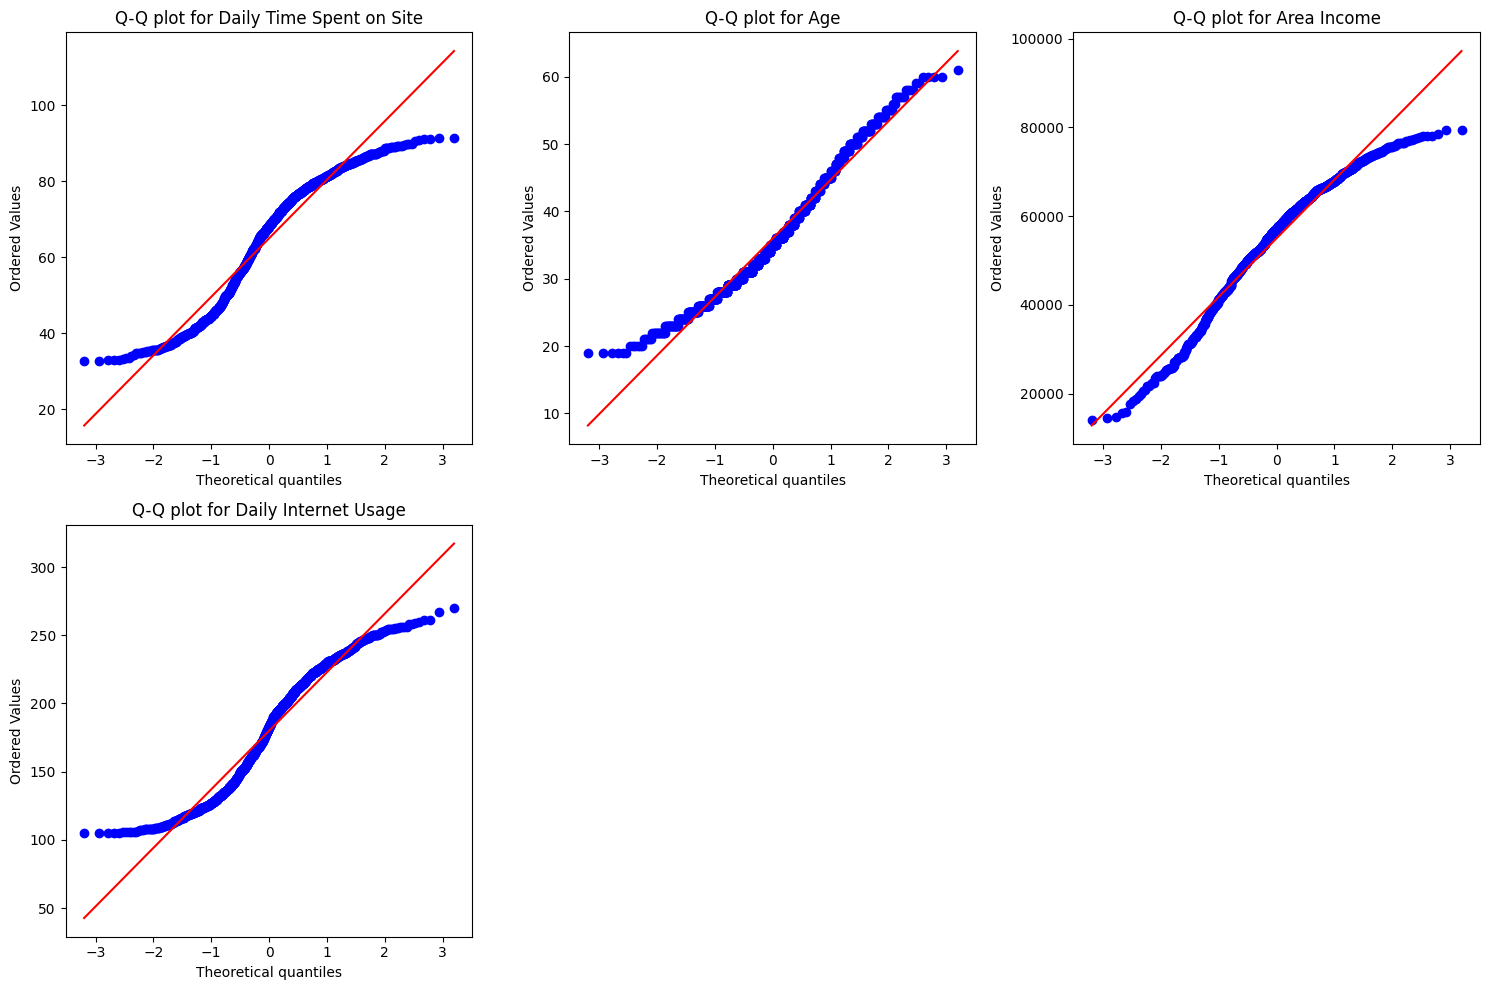

In [ ]:
continuous_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']

ncols = 3
nrows = math.ceil(len(continuous_cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    stats.probplot(df[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q plot for {col}')

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Inferences
 From the above graph, we can say that continuous cols are not normal. Lets check skewness and kuortosis

In [ ]:
stats = {}

for col in continuous_cols:
  stats[col] = {
      "Type" : df[col].dtype,
      "Skew": df[col].skew(),
      "Kurtosis": df[col].kurtosis()
  }

stats_df = pd.DataFrame(stats).T
stats_df

Type      Skew  Kurtosis
Daily Time Spent on Site  float64  -0.37176 -1.095534
Age                         int64  0.479142 -0.400524
Area Income               float64 -0.650373  -0.09981
Daily Internet Usage      float64 -0.033537 -1.272659

# Inference

Skew is < |1| and Kurtosis is < |2| which is in acceptable range - not heavy tailed or heavely skewed

# Test for Modality

To check if the data is multi model, we can first get the optimal bandwidth required for histogram. There are 3 plug in methods used:

1. Silverman - assumes normality of data,
2. ISJ (Improved Sheather-Jones) - does not asumes nomality of data,
3. Scott - asumes normality of data.

In [ ]:
def compare_bandwidths(df, col, plot=True):
    """
    Compare KDEs using ISJ, Scott, and Silverman bandwidths.

    Args:
        df (pd.DataFrame): Input DataFrame.
        col (str): Column to compute KDEs for.
        plot (bool): Whether to show the plot.

    Returns:
        dict: Dictionary of bandwidths used for each method.
    """
    data = df[col].dropna().values.reshape(-1, 1)
    bw_methods = ['ISJ', 'scott', 'silverman']
    bandwidths = {}

    if plot:
        plt.figure(figsize=(8, 5))

    for method in bw_methods:
        kde = FFTKDE(bw=method).fit(data)
        x, y = kde.evaluate()
        bandwidths[method] = kde.bw
        if plot:
            plt.plot(x, y, label=f"{method} (bw={kde.bw:.3f})")

    if plot:
        plt.hist(data, bins=30, density=True, alpha=0.3, color='gray', label="Histogram")
        plt.title(f"KDE Comparison for '{col}'")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return bandwidths

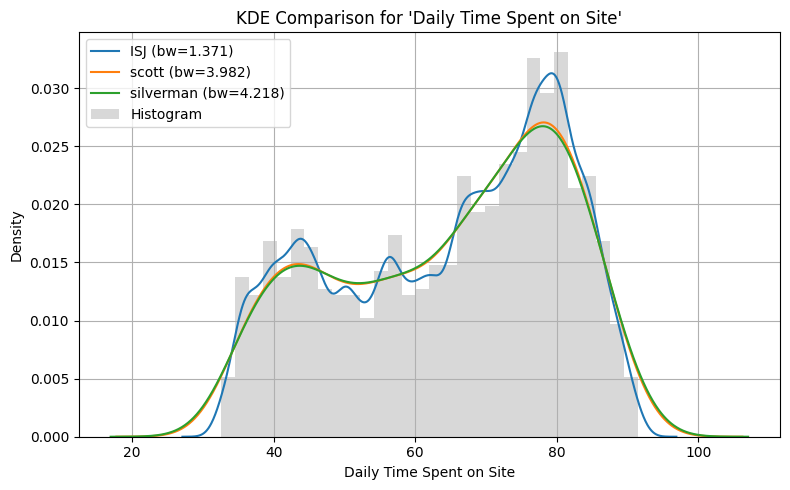

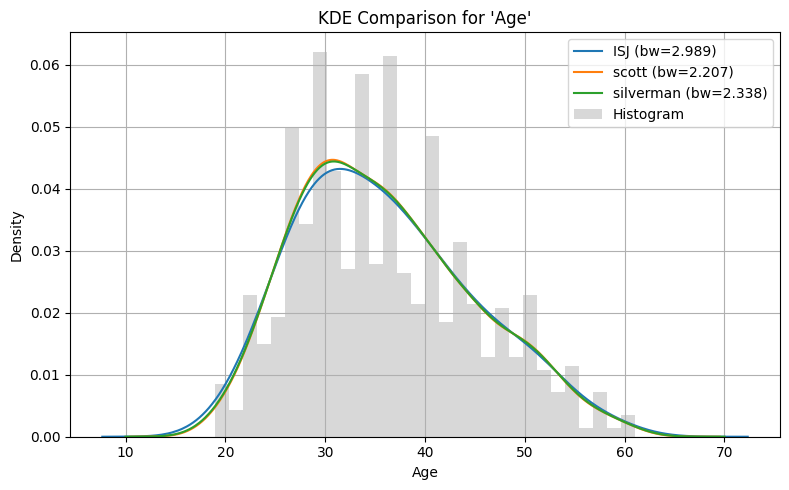

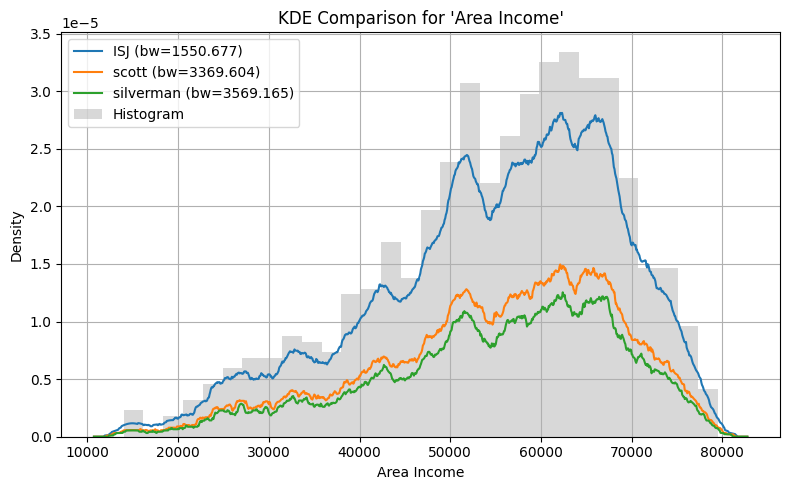

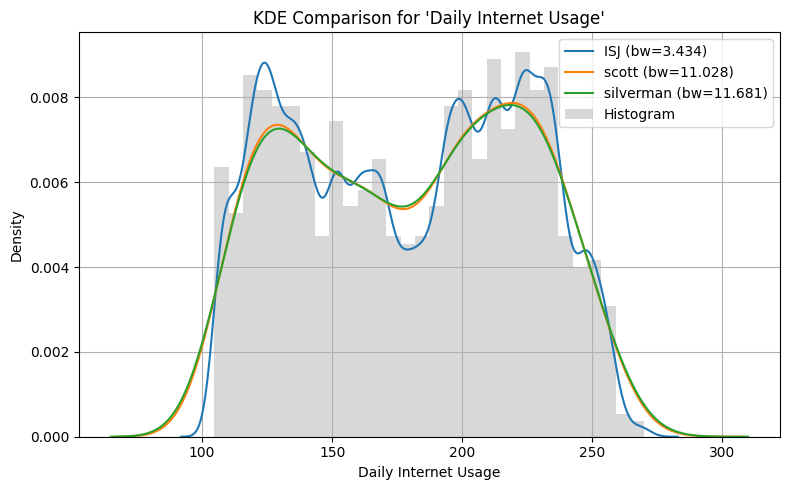

In [ ]:
for col in continuous_cols:
  compare_bandwidths(df, col)

# Inference
We could see that ISJ captures the most optimal bandwidth as it is closer to KDE approximation line

In [ ]:
def test_modality_with_kde(df, col, bw_method='ISJ', plot=True, peak_prominence=1e-5 ):

    data = df[col].dropna().values.reshape(-1, 1)

    # KDE with selected bandwidth
    kde = FFTKDE(bw=bw_method).fit(data)
    x, y = kde.evaluate()

    # Dip Test
    dip_stat, dip_p = diptest(data.flatten())

    # Count peaks
    peaks, _ = find_peaks(y, prominence=peak_prominence, width=40, distance=25)
    num_peaks = len(peaks)

    # Plot
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(x, y, label=f'KDE ({bw_method})', color='#191970', linewidth=2)
        sns.histplot(data=df, x=col, hue='Clicked on Ad', bins=25, stat='density', alpha=0.4, multiple='layer', palette={0: 'royalblue', 1: 'tomato'}, edgecolor=None)
        for p in x[peaks]:
            plt.axvline(p, color='red', linestyle='--', alpha=0.5)
        plt.title(f"{col} | Dip p={dip_p:.4f} | Peaks={num_peaks}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Decision
    modality = "Multimodal" if dip_p < 0.05 or num_peaks > 1 else "Unimodal"

    return {
        "column": col,
        "dip_stat": dip_stat,
        "dip_p_value": dip_p,
        "num_peaks": num_peaks,
        "bandwidth_used": bw_method,
        "modality": modality
    }


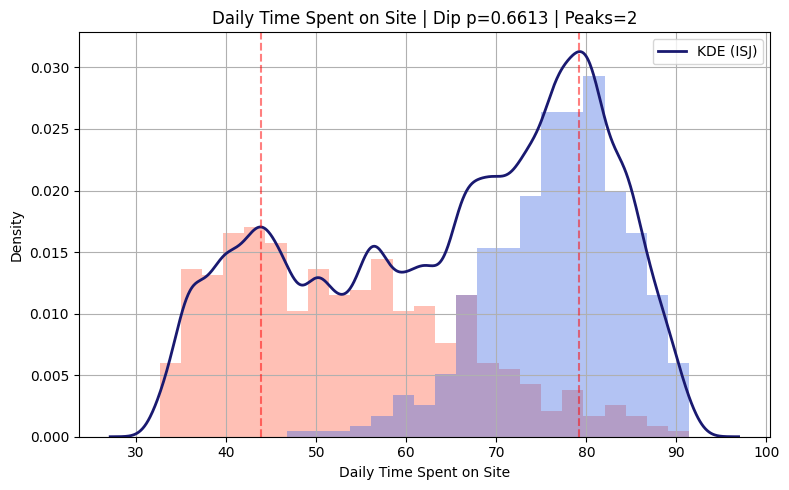

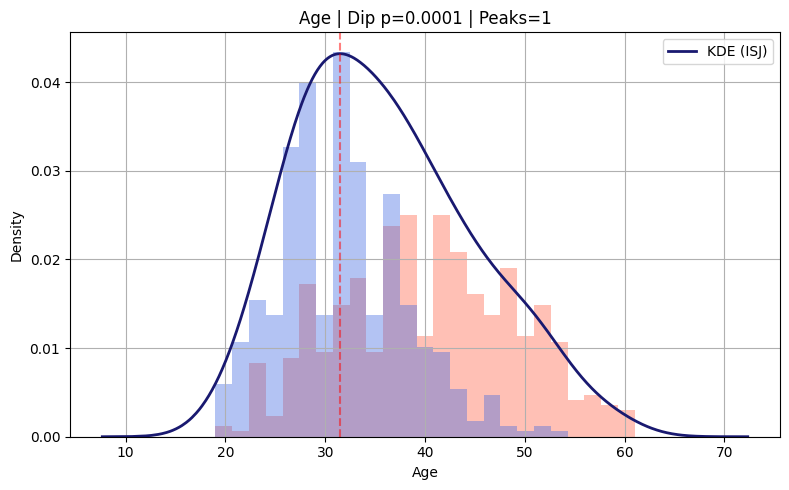

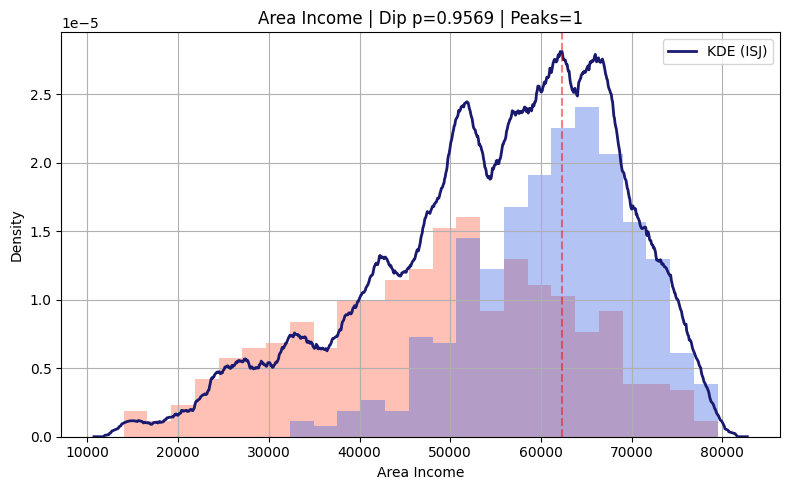

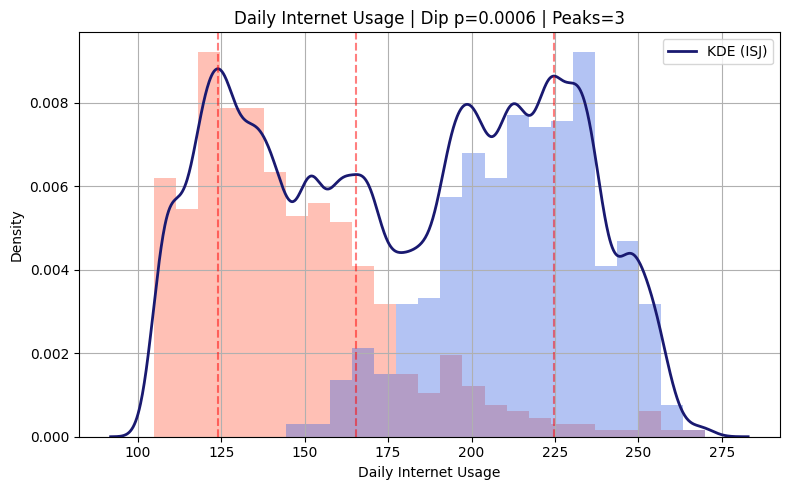

In [ ]:
for col in continuous_cols:
  test_modality_with_kde(df, col)

# Dip Test: Hypothesis Setup
Null Hypothesis (H₀):
The distribution is unimodal (has one mode or peak).

Alternative Hypothesis (H₁):
The distribution is not unimodal (i.e., it's multimodal: has 2 or more modes).

p < 0.05:

Reject H₀ → Not unimodal → Evidence of multimodality.

p ≥ 0.05:

Fail to reject H₀ → Cannot conclude multimodality → But not proof of unimodality.

# Inferences
### Modality Analysis Summary

| Case                        | Dip Test p-value | Peaks Detected | Interpretation                                                                                  | Conclusion        |
|----------------------------|------------------|----------------|--------------------------------------------------------------------------------------------------|-------------------|
| **1. Daily Time Spent**    | 0.6613           | 2              | High p-value (fail to reject unimodality), but KDE and grouped histogram show two clear peaks.   | Visually Bimodal  |
| **2. Age**                 | 0.0001           | 1              | Strong evidence against unimodality; peaks not resolved due to overlap, but groups are distinct. | Statistically Bimodal |
| **3. Area Income**         | 0.9569           | 1              | Very high p-value and only one peak; distribution is skewed but unimodal.                        | Unimodal          |
| **4. Daily Internet Usage**| 0.0006           | 3              | Strong rejection of unimodality; multiple clear peaks in KDE and grouped histograms. The middle peak does not looks significant from grouped histogram            | Bimodel        |


In [ ]:
def mann_whitney_test(df, feature, target='Clicked on Ad'):

    group0 = df[df[target] == 0][feature].dropna()
    group1 = df[df[target] == 1][feature].dropna()

    stat, p_value = mannwhitneyu(group0, group1, alternative='two-sided')

    conclusion = "Different distributions (p < 0.05)" if p_value < 0.05 else "No significant difference"

    return {
        'feature': feature,
        'statistic': stat,
        'p_value': p_value,
        'conclusion': conclusion
    }

mann_whitney_test_results = pd.DataFrame(map(lambda col: mann_whitney_test(df, col), continuous_cols))
mann_whitney_test_results

feature  statistic        p_value  \
0  Daily Time Spent on Site   232513.0  1.479071e-122   
1                       Age    54849.0   2.540746e-53   
2               Area Income   192438.0   2.375872e-49   
3      Daily Internet Usage   237093.5  4.762815e-133   

                           conclusion  
0  Different distributions (p < 0.05)  
1  Different distributions (p < 0.05)  
2  Different distributions (p < 0.05)  
3  Different distributions (p < 0.05)

# Categorical columns

In [ ]:
# Handle timestamps
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['day'] = df['Timestamp'].dt.day
df['month'] = df['Timestamp'].dt.month
df['year'] = df['Timestamp'].dt.year
df['hour'] = df['Timestamp'].dt.hour
df['15min'] = df['Timestamp'].dt.floor('15min').dt.strftime('%H:%M').astype(str)  # 15-minute Interval
df['Timestamp'].min(), df['Timestamp'].max()

(Timestamp('2016-01-01 02:52:10'), Timestamp('2016-07-24 00:22:16'))

 Note: SInce we have data from same year (2016) and 7 month, we don't need cyclic representation of month.

In [ ]:
df.groupby('15min')['Clicked on Ad'].mean().head()

15min
00:00    0.454545
00:15    0.500000
00:30    0.666667
00:45    0.750000
01:00    0.857143
Name: Clicked on Ad, dtype: float64

In [ ]:
def cos_sin_series(col, max_val):
  radians = 2* np.pi * df[col] / max_val
  df['cos_' + col] = np.cos(radians)
  df['sin_' + col] = np.sin(radians)


cos_sin_series('day', 31)
cos_sin_series('hour', 24)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Daily Time Spent on Site  1000 non-null   float64       
 1   Age                       1000 non-null   int64         
 2   Area Income               1000 non-null   float64       
 3   Daily Internet Usage      1000 non-null   float64       
 4   Ad Topic Line             1000 non-null   object        
 5   City                      1000 non-null   object        
 6   Male                      1000 non-null   int64         
 7   Country                   1000 non-null   object        
 8   Timestamp                 1000 non-null   datetime64[ns]
 9   Clicked on Ad             1000 non-null   int64         
 10  day                       1000 non-null   int32         
 11  month                     1000 non-null   int32         
 12  year                 

In [ ]:
def chi2_test(df, feature, target='Clicked on Ad'):
    contingency_table = pd.crosstab(df[feature], df[target])
    stat, p_value, _, _ = chi2_contingency(contingency_table)
    conclusion =  "Different distributions (p < 0.05)" if p_value < 0.05 else "No significant difference"
    return {
        'feature': feature,
        'p_value': p_value,
        'conclusion': conclusion
    }

cat_features = ['City', 'Male', 'Country']
results_cat = [chi2_test(df, f) for f in cat_features]
pd.DataFrame(results_cat)

feature   p_value                 conclusion
0     City  0.433956  No significant difference
1     Male  0.254602  No significant difference
2  Country  0.773757  No significant difference

Note:There is no significant difference in the distribution wrt to target "Clicked on Ad"

## Feature Engineering

In [ ]:
# Function to calculate click-through rate per time unit
def add_click_rate(df, time_col):
    click_rate = df.groupby(time_col)['Clicked on Ad'].mean().reset_index()
    click_rate.columns = [time_col, "click_rate_" + time_col]
    return df.merge(click_rate, on=time_col, how='left')

# Calculate and add CTR for hour, day, and month
df = add_click_rate(df, 'day')
df = add_click_rate(df, 'hour')
df = add_click_rate(df, '15min')

In [ ]:
# date features
date_features = ['day', 'month', 'year', 'hour', 'cos_day', 'sin_day', 'cos_hour', 'sin_hour', 'click_rate_day', 'click_rate_hour', 'click_rate_15min']
results_date = pd.DataFrame(map(lambda col: mann_whitney_test(df, col), date_features))
pd.DataFrame(results_date)

feature  statistic       p_value  \
0                day   125943.0  8.363962e-01   
1              month   122637.0  6.010143e-01   
2               year   125000.0  1.000000e+00   
3               hour   131886.0  1.312587e-01   
4            cos_day   122852.5  6.378735e-01   
5            sin_day   123285.0  7.071745e-01   
6           cos_hour   127193.0  6.306291e-01   
7           sin_hour   122699.5  6.140191e-01   
8     click_rate_day   101052.0  1.522396e-07   
9    click_rate_hour   107560.0  1.302782e-04   
10  click_rate_15min    83095.0  3.557870e-20   

                            conclusion  
0            No significant difference  
1            No significant difference  
2            No significant difference  
3            No significant difference  
4            No significant difference  
5            No significant difference  
6            No significant difference  
7            No significant difference  
8   Different distributions (p < 0.05)  
9   Different distributions (p < 0.05)  
10  Different distributions (p < 0.05)

Note: There is no significant difference in the distribution wrt to target "Clicked on Ad" except for features Click through rate per day / hour / 10 minute.

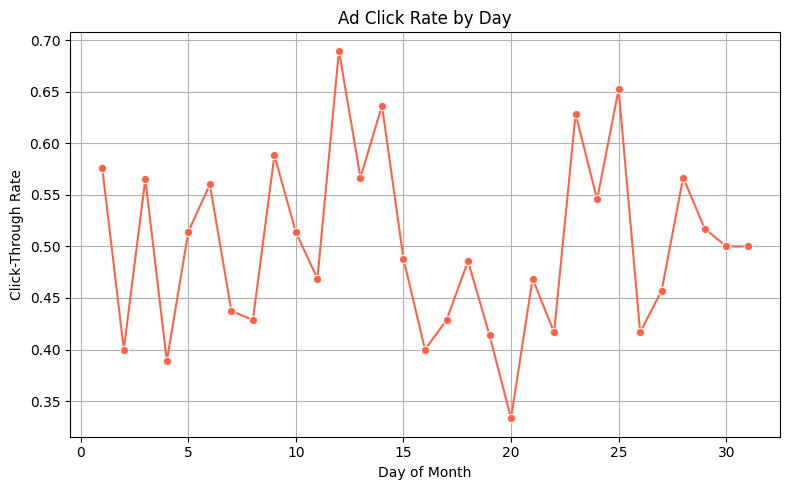

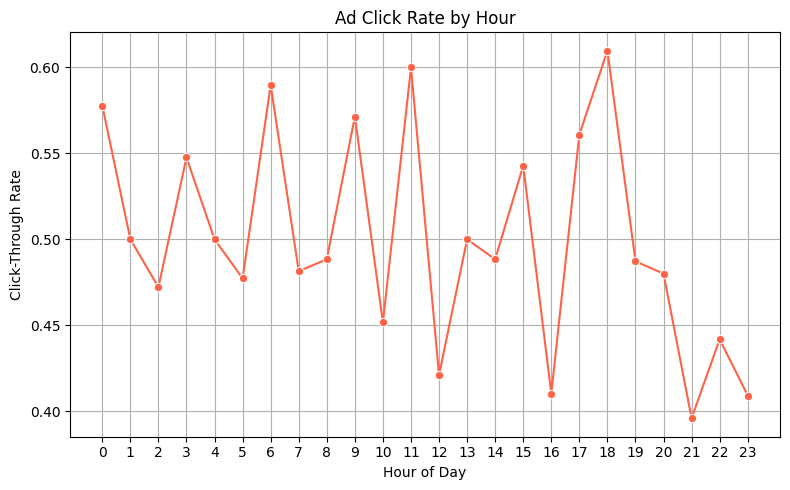

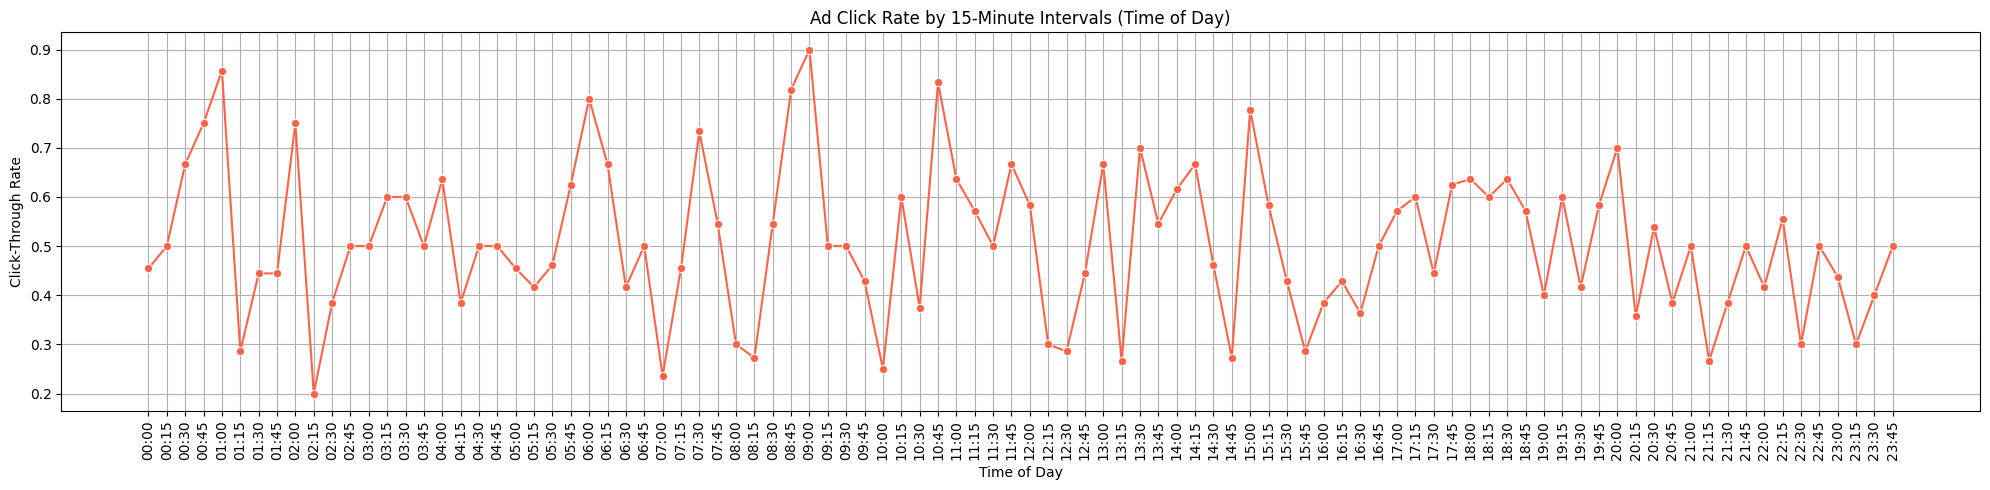

In [ ]:
# Click rate = mean of target for each time group
click_rates_day = df.groupby('day')['Clicked on Ad'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=click_rates_day, x='day', y='Clicked on Ad', marker='o', color='tomato')
plt.title("Ad Click Rate by Day")
plt.ylabel("Click-Through Rate")
plt.xlabel("Day of Month")
plt.grid(True)
plt.tight_layout()
plt.show()

# Click rate = mean of target for each time group
click_rates_hour = df.groupby('hour')['Clicked on Ad'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=click_rates_hour, x='hour', y='Clicked on Ad', marker='o', color='tomato')
plt.title("Ad Click Rate by Hour")
plt.ylabel("Click-Through Rate")
plt.xlabel("Hour of Day")
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


click_rates_15min = df.groupby('15min')['Clicked on Ad'].mean().reset_index()

plt.figure(figsize=(20, 5))
sns.lineplot(data=click_rates_15min, x='15min', y='Clicked on Ad', marker='o', color='tomato')
plt.title("Ad Click Rate by 15-Minute Intervals (Time of Day)")
plt.ylabel("Click-Through Rate")
plt.xlabel("Time of Day")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

## Inference

### Ad Click Rate Insights Across Time
1. Ad Click Rate by Day of Month
  * Click behavior varies substantially across different days.
  * Peaks around days 13–14, 24–25 show higher engagement.

  * Some dips around day 19–21 suggest low activity or lower ad effectiveness on those days.

  * No clear weekly trend, suggesting external factors may influence user behavior.

2. Ad Click Rate by Hour of Day
  * Higher click activity observed in the early hours (0–6 AM) and mid-morning (10–12 PM).

  * Evening hours (18–20 PM) also show elevated engagement.

  * Late night (after 21 PM) shows a decline in click rate.

  * Suggests potential for time-based ad targeting to maximize user interaction.

3. Ad Click Rate by 15-Minute Intervals
  * Finer time resolution reveals sharp spikes in engagement:

  * Notably at 01:15 AM, 08:45 AM, 10:45 AM.

  * Periods like 8 AM to 11 AM and 7 PM to 9 PM show sustained click rates.

  * Click behavior is highly dynamic, emphasizing the value of precise scheduling for campaign delivery.

# Encoding

In [ ]:
# drop this column as this as same length as index
df['Ad Topic Line'].nunique(), df.index
df.drop(columns={'Ad Topic Line'}, axis=1, inplace=True)

In [ ]:
df['City'].nunique(), df['Country'].nunique()
# We use embedding layer to map categories to set of arays

(969, 237)

In [ ]:
df.drop(columns={'Timestamp'}, axis = 1, inplace = True)

In [ ]:
# Columns to exclude from the pipeline
excluded_cols = ['City', 'Country']

except_col = excluded_cols + ['Clicked on Ad', '15min']
num_cols = [col for col in df.columns if col not in except_col]
num_cols

['Daily Time Spent on Site',
 'Age',
 'Area Income',
 'Daily Internet Usage',
 'Male',
 'day',
 'month',
 'year',
 'hour',
 'cos_day',
 'sin_day',
 'cos_hour',
 'sin_hour',
 'click_rate_day',
 'click_rate_hour',
 'click_rate_15min']

In [ ]:
cat_cols = ['Male', 'City', 'Country']
df[cat_cols].astype('category')

cat_cols_to_embed = ['City', 'Country']

# Feature Engineering

In [ ]:
# Feature Engineering

df['click_rate_day'] = df['day'].map(df.groupby('day')['Clicked on Ad'].mean())
df['click_rate_hour'] = df['hour'].map(df.groupby('hour')['Clicked on Ad'].mean())
df['click_rate_15min'] = df['15min'].map(df.groupby('15min')['Clicked on Ad'].mean())

df.drop(columns=['15min'], axis=1, errors='ignore', inplace=True)

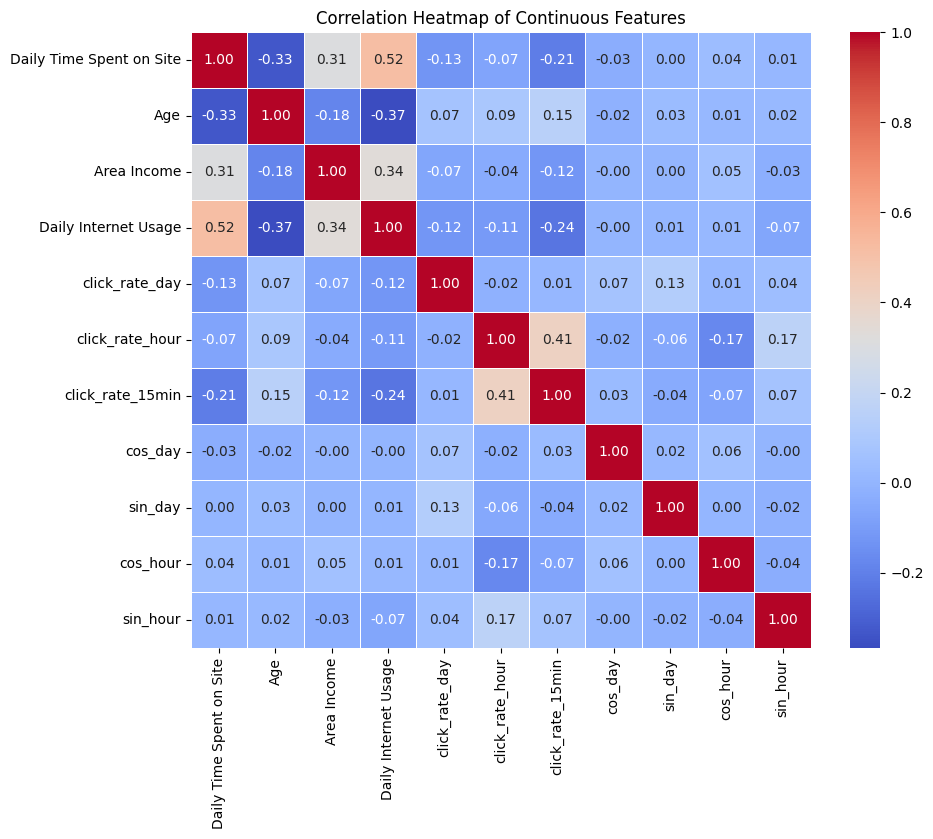

In [ ]:
continuous_features = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'click_rate_day', 'click_rate_hour', 'click_rate_15min', 'cos_day', 'sin_day', 'cos_hour', 'sin_hour']
plt.figure(figsize=(10, 8))
sns.heatmap(df[continuous_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Continuous Features')
plt.show()

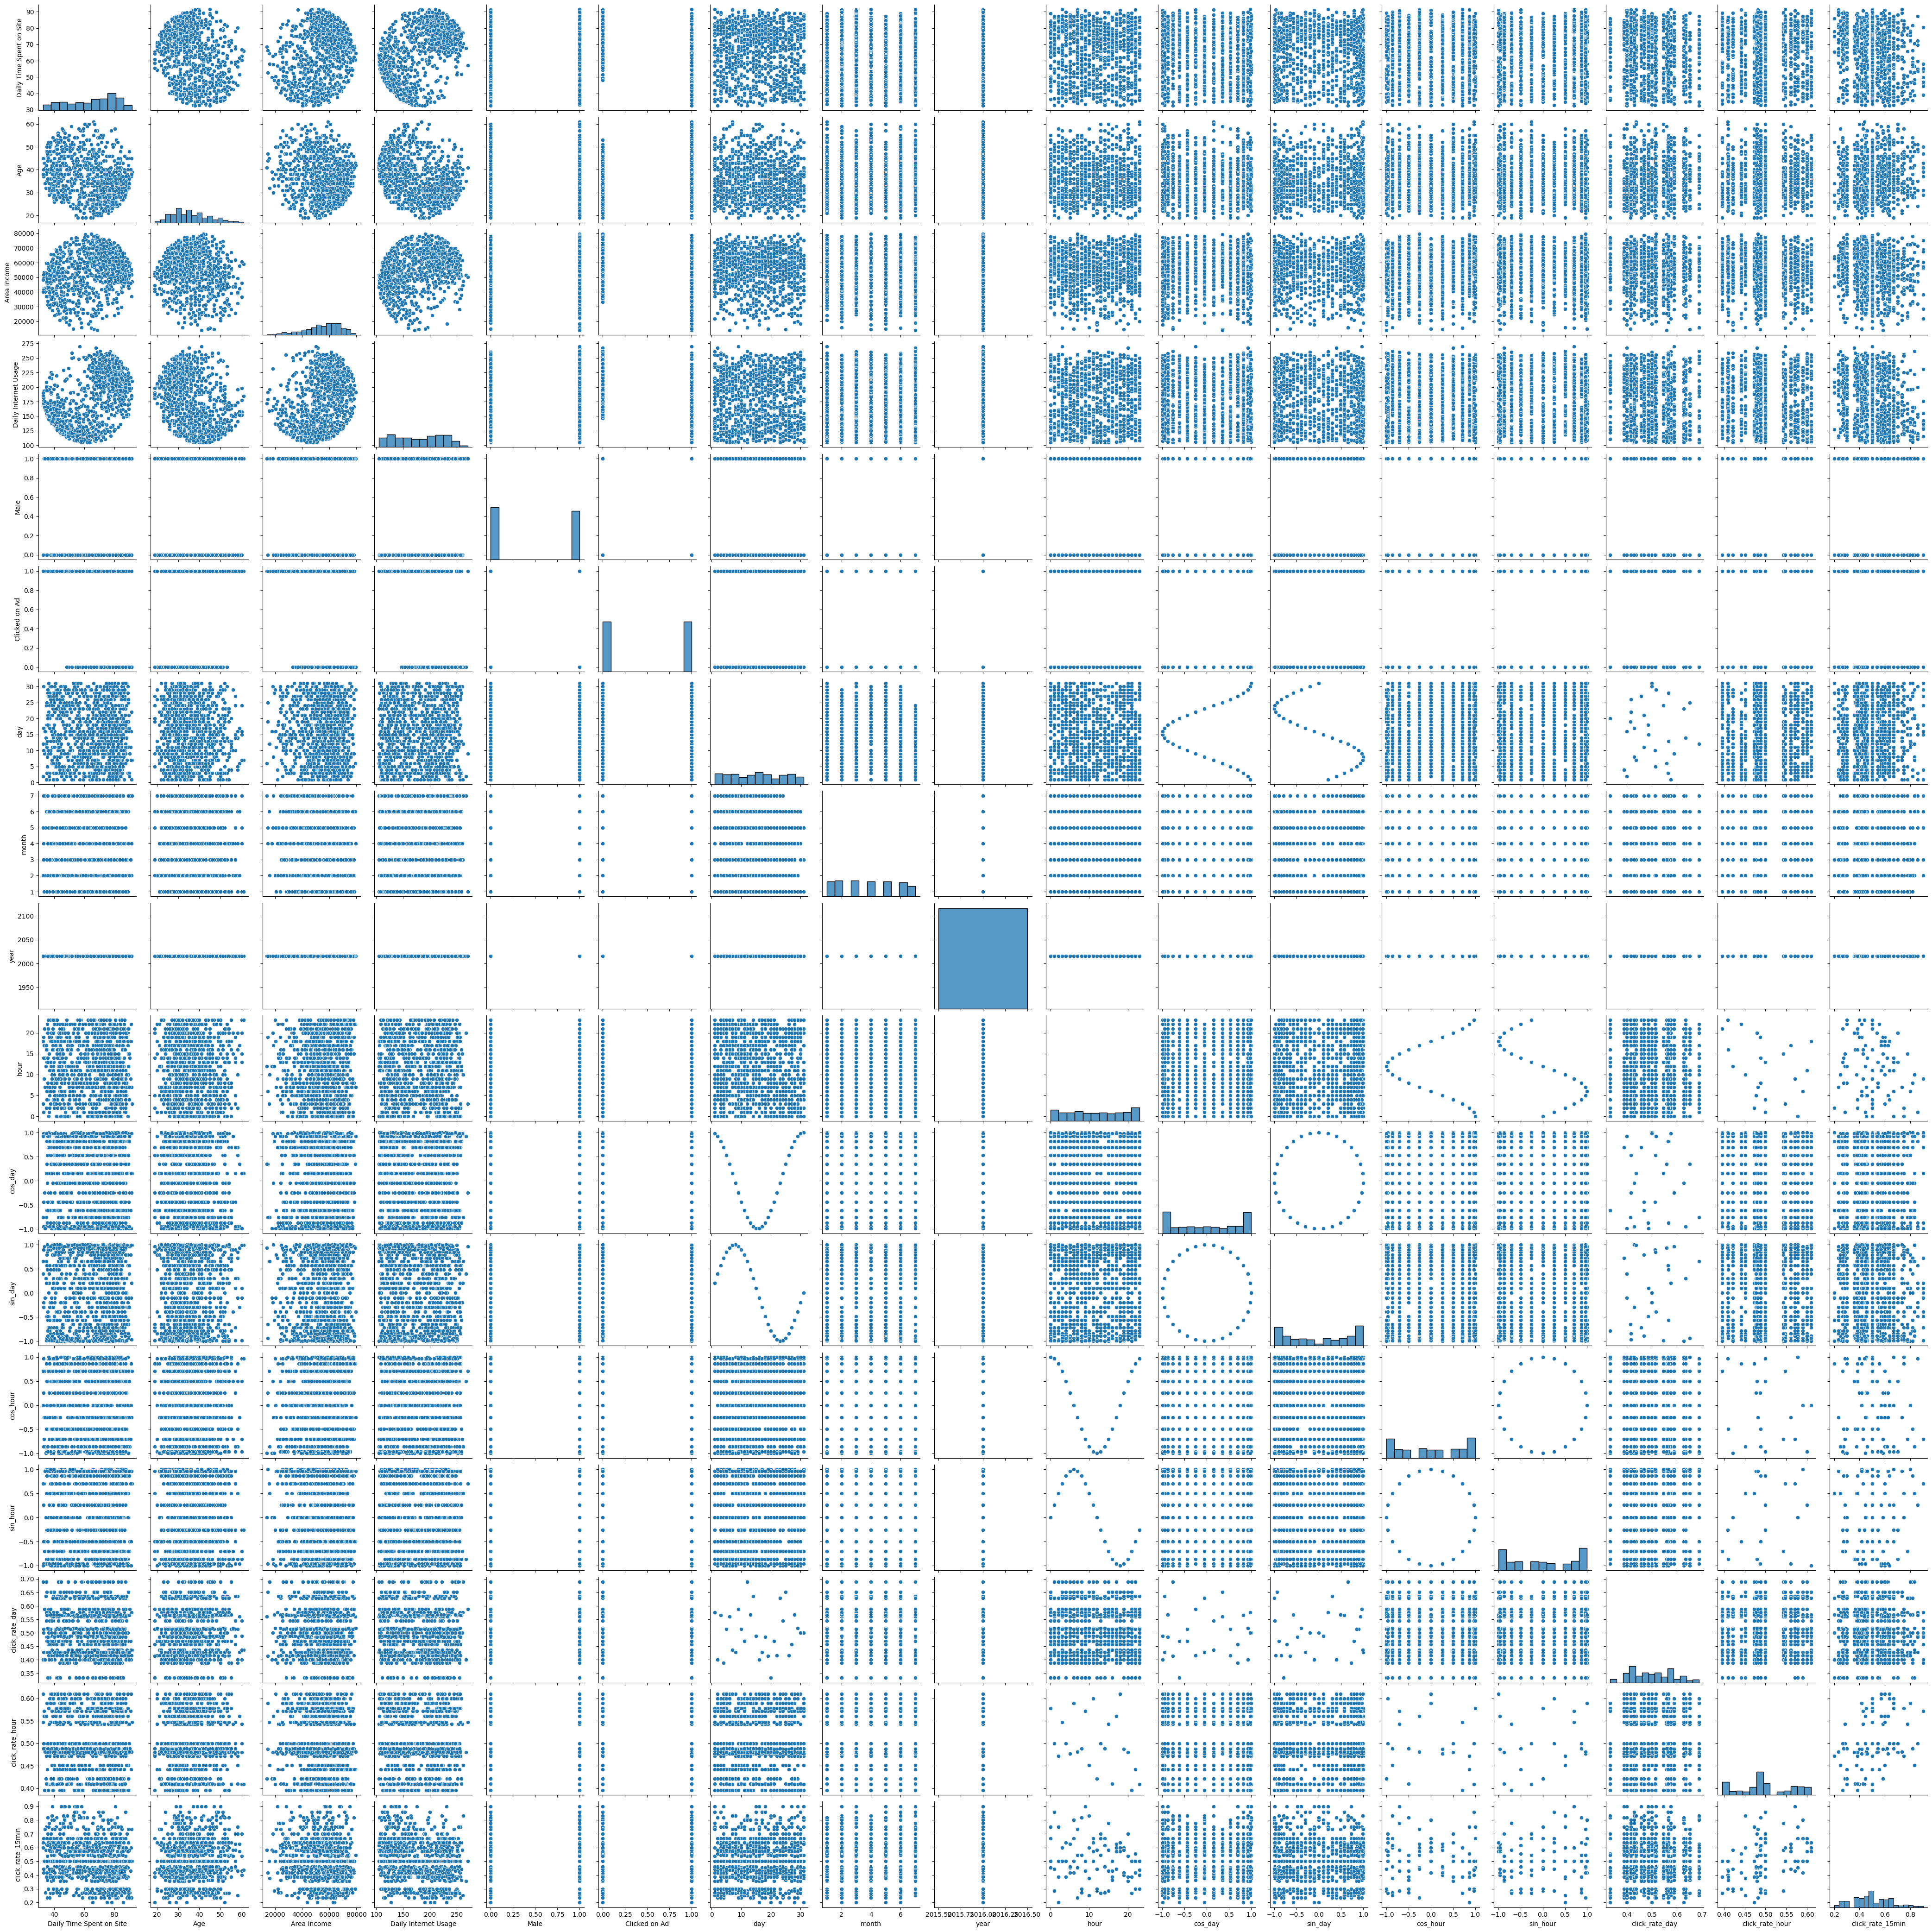

In [ ]:
sns.pairplot(df)
plt.show()

# Pipeline

In [ ]:
# numerical pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# categorical imputer (for all cat columns)
cat_imputer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# pipeline for embedding columns (impute + ordinal encode)
cat_embed_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# 4. column transformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat_non_embed', cat_imputer, list(set(cat_cols) - set(cat_cols_to_embed))),
    ('cat_embed', cat_embed_pipeline, cat_cols_to_embed)
])

transform_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [ ]:
transform_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Daily Time Spent on Site',
                                                   'Age', 'Area Income',
                                                   'Daily Internet Usage',
                                                   'Male', 'day', 'month',
                                                   'year', 'hour', 'cos_day',
                                                   'sin_day', 'cos_hour',
                                                   'sin_hour', 'click_rate_day',
                                                   'click_rate_hour',
                                                   'click_rate_15min']),
                                                 ('cat_non_embed',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Male']),
                                                 ('cat_embed',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['City', 'Country'])]))])

In [ ]:
# Original dataset
X, y = df.drop(columns=['Clicked on Ad']), df['Clicked on Ad']

# Calculate split sizes
train_val_size = 0.8 # training & validation set
test_size = 1 - train_val_size # 0.2

# (Train + val) + Temp split
X_val_train, X_test, y_val_train, y_test = train_test_split(
    X, y,
    test_size= test_size,  # 0.2 test set size
    stratify=y,
    random_state=42
)

# Sanity check
print(f'Train_Val: {len(X_val_train)}, Test: {len(X_test)}')


Train_Val: 800, Test: 200


In [ ]:
base = df.copy(deep=True)

base_X, base_y = base.drop(columns=['Clicked on Ad']), base['Clicked on Ad']

lb = LabelEncoder()
base_X['City'] = lb.fit_transform(base_X['City'])
base_X['Country'] = lb.fit_transform(base_X['Country'])

base_X_train, base_X_test, base_y_train, base_y_test = train_test_split(base_X, base_y, test_size=0.2, random_state=42)

# Unprocessed version - we will use this for ANN model
ann_X_test = base_X_test.copy(deep=True)
ann_y_test = base_y_test.copy(deep=True)

# --- Scale only on train set ---
scaler_ = StandardScaler()
base_X_train = scaler_.fit_transform(base_X_train)
base_X_test = scaler_.transform(base_X_test)

base_X_train.shape, base_X_test.shape

((800, 18), (200, 18))

In [ ]:

base_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
}

base_model_metrics = []
for model_name, model in base_models.items():
    model.fit(base_X_train, base_y_train)
    y_pred = model.predict(base_X_test)
    y_proba = model.predict_proba(base_X_test)[:, 1]  # For ROC AUC

    accuracy = accuracy_score(base_y_test, y_pred)
    precision = precision_score(base_y_test, y_pred)
    recall = recall_score(base_y_test, y_pred)
    f1 = f1_score(base_y_test, y_pred)
    roc_auc = roc_auc_score(base_y_test, y_proba)
    cm = confusion_matrix(base_y_test, y_pred)

    base_model_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': cm
    })

base_model_metrics

[{'Model': 'Logistic Regression',
  'Accuracy': 0.95,
  'Precision': 0.9719626168224299,
  'Recall': 0.9369369369369369,
  'F1 Score': 0.9541284403669725,
  'ROC AUC': np.float64(0.983804028747849),
  'Confusion Matrix': array([[ 86,   3],
         [  7, 104]])},
 {'Model': 'Decision Tree',
  'Accuracy': 0.925,
  'Precision': 0.9363636363636364,
  'Recall': 0.9279279279279279,
  'F1 Score': 0.9321266968325792,
  'ROC AUC': np.float64(0.9246381212673347),
  'Confusion Matrix': array([[ 82,   7],
         [  8, 103]])},
 {'Model': 'Random Forest',
  'Accuracy': 0.93,
  'Precision': 0.944954128440367,
  'Recall': 0.9279279279279279,
  'F1 Score': 0.9363636363636364,
  'ROC AUC': np.float64(0.9770725781961735),
  'Confusion Matrix': array([[ 83,   6],
         [  8, 103]])}]

# Build Torch Model

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, numeric_tensor, embed_tensors_dict, target_tensor):
        self.numeric_tensor = numeric_tensor
        self.embed_tensors_dict = embed_tensors_dict
        self.target_tensor = target_tensor

    def __len__(self):
        return len(self.target_tensor)

    def __getitem__(self, idx):
        numeric_data = self.numeric_tensor[idx]
        embed_data = {col: self.embed_tensors_dict[col][idx] for col in self.embed_tensors_dict}
        target = self.target_tensor[idx]
        return numeric_data, embed_data, target

In [ ]:
class CategoricalANN(nn.Module):
    def __init__(self, config, vocab_sizes):
        super().__init__()
        self.config = config
        self.vocab_sizes = vocab_sizes  # Dict[str, int]
        self.num_features = config.num_features
        self.hidden_size = config.hidden_size
        self.dropout_rate = config.dropout_rate

        # Embedding layers for categorical columns
        self.embeddings = nn.ModuleDict({
            col_name: nn.Embedding(vocab_size, config.embedding_dims[col_name])
            for col_name, vocab_size in vocab_sizes.items()
        })

        total_embedding_dim = sum(config.embedding_dims[col] for col in vocab_sizes)

        # Adjust input dimension for embedded categorical features
        input_dim = self.num_features - len(self.vocab_sizes) + total_embedding_dim

        self.fc1 = nn.Linear(input_dim, self.hidden_size)
        self.bn1 = nn.BatchNorm1d(self.hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(self.hidden_size, 1)

    def forward(self, numerical_inputs, categorical_inputs_embed_dict):
        """
        Args:
            numerical_inputs (Tensor): shape (batch_size, num_numerical_features)
            categorical_inputs_embed_dict (Dict[str, Tensor]): each tensor shape (batch_size,)
        """
        embedded_outputs = []

        for col_name, tensor in categorical_inputs_embed_dict.items():
            tensor = tensor.clone()  # avoid in-place ops
            if (tensor == -1).any():  # replace unknowns with last index
                tensor[tensor == -1] = self.vocab_sizes[col_name] - 1
            embedded = self.embeddings[col_name](tensor)
            embedded_outputs.append(embedded)

        # Concatenate all embeddings
        categorical_embedded = torch.cat(embedded_outputs, dim=1)

        # Final input: numerical + embedded categorical
        x = torch.cat([numerical_inputs, categorical_embedded], dim=1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
class CategoricalANNConfig:
    def __init__(self, model_cls, num_features, embedding_dims, hidden_size=128, dropout_rate=0.3):
        self.model_cls = model_cls
        self.num_features = num_features
        self.embedding_dims = embedding_dims
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

config = CategoricalANNConfig(
        model_cls=CategoricalANN,
        num_features=19,
        embedding_dims={'City': 32, 'Country': 16},
        hidden_size=128,
        dropout_rate=0.3
    )

for k, v in vars(config).items():
  print(f"{k}: {v}")

model_cls: <class '__main__.CategoricalANN'>
num_features: 19
embedding_dims: {'City': 32, 'Country': 16}
hidden_size: 128
dropout_rate: 0.3


In [ ]:
def get_metrics() -> dict:
    """Return a dictionary of default binary classification metrics from torchmetrics.

    Returns:
        dict: Dictionary mapping metric names to torchmetrics.Metric instances.
    """
    return {
        "accuracy": BinaryAccuracy(),
        "precision": BinaryPrecision(),
        "recall": BinaryRecall(),
        "f1_score": BinaryF1Score(),
        "confusion_matrix": BinaryConfusionMatrix(),
        "auroc": BinaryAUROC(),
        "average_precision": BinaryAveragePrecision()
    }

def get_optimizer(model_params, name: str = "Adam", params: dict = None) -> optim.Optimizer:
    """Return a PyTorch optimizer instance.

    Args:
        model_params (iterable): Model parameters to optimize.
        name (str): Name of the optimizer. Defaults to 'Adam'.
        params (dict, optional): Optimizer hyperparameters. Defaults to None.

    Returns:
        torch.optim.Optimizer: Initialized optimizer instance.

    Raises:
        ValueError: If the optimizer name is invalid.
    """
    params = params or {"lr": 1e-3}  # Default learning rate
    try:
        optimizer_class = getattr(torch.optim, name)
        return optimizer_class(model_params, **params)
    except AttributeError:
        raise ValueError(f"Optimizer '{name}' not found in torch.optim")

def get_loss_fn(name: str = "BCEWithLogitsLoss", params: dict = None) -> nn.Module:
    """Return a PyTorch loss function instance.

    Args:
        name (str): Name of the loss function. Defaults to 'BCEWithLogitsLoss'.
        params (dict, optional): Loss function parameters. Defaults to None.

    Returns:
        torch.nn.Module: Initialized loss function.

    Raises:
        ValueError: If the loss function name is invalid.
    """
    params = params or {}
    try:
        loss_class = getattr(nn, name)
        return loss_class(**params)
    except AttributeError:
        raise ValueError(f"Loss function '{name}' not found in torch.nn")

def get_scheduler(optimizer, name: str = "StepLR", params: dict = None) -> optim.lr_scheduler._LRScheduler:
    """Return a PyTorch learning rate scheduler instance.

    Args:
        optimizer (torch.optim.Optimizer): Optimizer to attach the scheduler to.
        name (str): Name of the scheduler. Defaults to 'StepLR'.
        params (dict, optional): Scheduler parameters. Defaults to None.

    Returns:
        torch.optim.lr_scheduler._LRScheduler: Initialized scheduler instance.

    Raises:
        ValueError: If the scheduler name is invalid.
    """
    params = params or {"step_size": 10, "gamma": 0.1}  # Default for StepLR
    try:
        scheduler_class = getattr(torch.optim.lr_scheduler, name)
        return scheduler_class(optimizer, **params)
    except AttributeError:
        raise ValueError(f"Scheduler '{name}' not found in torch.optim.lr_scheduler")

In [ ]:
class CustomKFoldTrainerANN:
    def __init__(self, config=None, device=None, epochs=10, batch_size=32, learning_rate=1e-3,
                 use_kfold=False, n_splits=5, patience=5, use_amp=False, transform_pipeline=None,
                 best_metric="val_auc", clip_grad_norm_val=1.0, early_stopping=False, cols_to_embed=None):
        self.config = config
        self.device = device or torch.device("cpu")
        self.model = None
        self.loss_fn = self._get_loss_fn()
        self.epochs = epochs
        self.current_epoch = 0
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.use_kfold = use_kfold
        self.n_splits = n_splits
        self.patience = patience
        self.use_amp = use_amp and torch.cuda.is_available()
        self.scaler = GradScaler() if self.use_amp else None
        self.transform_pipeline = transform_pipeline
        self.best_metric = best_metric
        self.clip_grad_norm_val = clip_grad_norm_val
        self.early_stopping = early_stopping
        self.metrics = MetricCollection(get_metrics()).to(self.device)
        self.vocab_embed = None
        self.cols_to_embed = cols_to_embed

    def _get_optimizer(self, params):
        return get_optimizer(params)

    def _get_scheduler(self, optimizer):
        return get_scheduler(optimizer)

    def _get_loss_fn(self):
        return get_loss_fn()

    def _reset_training_state(self):
        if self.vocab_embed is None:
            raise ValueError("vocab_embed must be set before training.")
        self.model = self.config.model_cls(self.config, self.vocab_embed).to(self.device)
        self.optimizer = self._get_optimizer(self.model.parameters())
        self.scheduler = self._get_scheduler(self.optimizer)
        if self.use_amp:
            self.scaler = GradScaler()
        self.metrics.reset()

    def _training_loop(self, train_loader, pbar):
        self.model.train()
        total_loss = 0.0
        self.metrics.reset()

        for batch in train_loader:
            *inputs, targets = batch
            inputs[0] = inputs[0].to(self.device)
            inputs[1] = {k: v.to(self.device) for k, v in inputs[1].items()}
            targets = targets.to(self.device)

            self.optimizer.zero_grad()
            if self.use_amp:
                with autocast('cuda'):
                    outputs = self.model(*inputs)
                    loss = self.loss_fn(outputs, targets.view(-1, 1))
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm_val)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(*inputs)
                loss = self.loss_fn(outputs, targets.view(-1, 1))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm_val)
                self.optimizer.step()

            total_loss += loss.item()
            preds = torch.sigmoid(outputs)
            self.metrics.update(preds, targets.view(-1, 1).to(torch.long))
            pbar.update()

        if not isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step()

        train_metrics = self.metrics.compute()

        return {
                "loss": total_loss / len(train_loader),
                **{k: (v.numpy() if v.ndim > 0 else v.item()) for k, v in train_metrics.items()}

        }

    def _evaluation_loop(self, val_loader, pbar):
        self.model.eval()
        total_loss = 0.0
        self.metrics.reset()

        with torch.no_grad():
            for batch in val_loader:
                *inputs, targets = batch
                inputs[0] = inputs[0].to(self.device)
                inputs[1] = {k: v.to(self.device) for k, v in inputs[1].items()}
                targets = targets.to(self.device)

                outputs = self.model(*inputs)
                loss = self.loss_fn(outputs, targets.view(-1, 1))
                total_loss += loss.item()
                preds = torch.sigmoid(outputs)
                self.metrics.update(preds, targets.view(-1, 1).to(torch.long))
                pbar.update()

        val_metrics = self.metrics.compute()
        return {
                "loss": total_loss / len(val_loader),
                **{k: (v.numpy() if v.ndim > 0 else v.item()) for k, v in val_metrics.items()}
            }

    def to_dataloaders(self, X, y, col_map_to_embed, shuffle=False):
        if isinstance(X, pd.DataFrame):
            X = X.values
        numeric_indices = [i for i in range(X.shape[1]) if i not in col_map_to_embed.values()]

        numeric_tensor = torch.tensor(X[:, numeric_indices], dtype=torch.float32)
        embed_tensors_dict = {col: torch.tensor(X[:, idx], dtype=torch.long) for col, idx in col_map_to_embed.items()}
        target_tensor = torch.tensor(y.values, dtype=torch.float32).squeeze()

        dataset = CustomDataset(numeric_tensor, embed_tensors_dict, target_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train_model(self, X_train, y_train, X_val, y_val, **kwargs):
        checkpoint_dir = kwargs.get("checkpoint_dir", "checkpoints")
        pipeline = kwargs.get("transform_pipeline", self.transform_pipeline)
        early_stopping = kwargs.get("early_stopping", self.early_stopping)

        self.vocab_embed = {col: pd.concat([X_train[col], X_val[col]]).nunique() + 1 for col in self.cols_to_embed}

        if pipeline:
            X_train = pipeline.fit_transform(X_train)
            X_val = pipeline.transform(X_val)

        feature_names = [col.split('__')[-1] for col in pipeline.get_feature_names_out()]
        col_map_to_embed = {col: idx for idx, col in enumerate(feature_names) if col in self.cols_to_embed}

        train_loader = self.to_dataloaders(X_train, y_train, col_map_to_embed, shuffle=True)
        val_loader = self.to_dataloaders(X_val, y_val, col_map_to_embed)

        self._reset_training_state()
        best_val_metric = -float("inf") if "loss" not in self.best_metric else float("inf")
        best_model_state = None
        best_epoch_idx = 0
        history = []

        for epoch in range(self.epochs):
            self.current_epoch = epoch + 1
            total_batches = len(train_loader) + len(val_loader)

            with tqdm(total=total_batches, desc=f"Epoch {epoch + 1}/{self.epochs}", unit="batch") as pbar:
                train_metrics = self._training_loop(train_loader, pbar)
                val_metrics = self._evaluation_loop(val_loader, pbar)

                pbar.set_postfix({
                "loss": f"{train_metrics.get('loss'):.4f}",
                "acc": f"{train_metrics.get('accuracy', 0.0):.4f}",
                "val_loss": f"{val_metrics.get('loss'):.4f}",
                "val_acc": f"{val_metrics.get('accuracy', 0.0):.4f}"
            })

            history.append({"epoch": epoch + 1, "train" : train_metrics, "val" : val_metrics})
            current_val_metric = val_metrics[self.best_metric]

            is_better = current_val_metric < best_val_metric if "loss" in self.best_metric else current_val_metric > best_val_metric
            if is_better:
                best_val_metric = current_val_metric
                best_epoch_idx = epoch
                best_model_state = copy.deepcopy(self.model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            if self.scheduler and isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_metrics["val_loss"])

            if early_stopping and patience_counter >= self.patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
                break

        os.makedirs(checkpoint_dir, exist_ok=True)
        model_path = os.path.join(checkpoint_dir, "best_model.pt")
        pipeline_path = os.path.join(checkpoint_dir, "pipeline.pkl")
        if pipeline:
            with open(pipeline_path, "wb") as f:
                pickle.dump(pipeline, f)
        torch.save(best_model_state, model_path)

        return {"best_model_path": model_path, "best_pipeline_path":pipeline_path, "best_epoch" : best_epoch_idx, "history": history}

    def train_model_KFold(self, X_train_val, y_train_val, **kwargs):
        checkpoint_dir = kwargs.get("checkpoint_dir", "checkpoints")
        n_splits = kwargs.get("n_splits", self.n_splits)
        pipeline = kwargs.get("transform_pipeline", self.transform_pipeline)

        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        history_all_folds = []

        for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train_val)):
            print(f"\n{'='*30}")
            print(f"Fold {fold_idx + 1}/{n_splits}")
            print(f"{'='*30}\n")
            X_train = X_train_val.iloc[train_idx]
            y_train = y_train_val.iloc[train_idx]
            X_val = X_train_val.iloc[val_idx]
            y_val = y_train_val.iloc[val_idx]

            history = self.train_model(
                X_train, y_train, X_val, y_val, cols_to_embed=self.cols_to_embed,
                checkpoint_dir=checkpoint_dir, transform_pipeline=pipeline
            )
            history_all_folds.append(history)

        best_fold_idx = np.argmax([history['history'][history['best_epoch']]['val'][self.best_metric] for history in history_all_folds])
        best_fold_result = {
            "best_fold": int(best_fold_idx),
            "best_model_path" : history_all_folds[best_fold_idx]['best_model_path'],
            "best_pipeline_path" : history_all_folds[best_fold_idx]['best_pipeline_path'],
            **history_all_folds[best_fold_idx]['history'][history.get('best_epoch')]
        }

        return best_fold_result, history_all_folds

    def test_model(self, X_test, y_test, best_pipeline_path = None, best_model_path=None):
        # Load best weights before evaluation
        if best_model_path is not None:
            self.model.load_state_dict(torch.load(best_model_path, map_location=self.device))
            print(f" Loaded best model from: {best_model_path}")
        else:
            print("⚠️ Warning: No model checkpoint path provided. Using current model state.")

        if best_pipeline_path is not None:
            with open(best_pipeline_path, "rb") as f:
                self.transform_pipeline = pickle.load(f)

        self.model.eval()

        X_test = self.transform_pipeline.transform(X_test)

        feature_names = [col.split('__')[-1] for col in self.transform_pipeline.get_feature_names_out()]
        col_map_to_embed = {col: idx for idx, col in enumerate(feature_names) if col in self.cols_to_embed}

        test_loader = self.to_dataloaders(X_test, y_test, col_map_to_embed, shuffle=False)
        self.metrics.reset()
        total_loss = 0.0

        with torch.no_grad():
            for batch in test_loader:
                *inputs, targets = batch

                inputs[0] = inputs[0].to(self.device)
                inputs[1] = {k: v.to(self.device) for k, v in inputs[1].items()}
                targets = targets.to(self.device)

                outputs = self.model(*inputs)
                loss = self.loss_fn(outputs, targets.view(-1, 1))
                total_loss += loss.item()
                preds = torch.sigmoid(outputs)
                self.metrics.update(preds, targets.view(-1, 1).to(torch.long))

        test_metrics = self.metrics.compute()
        return {"test":{
                "loss": total_loss / len(test_loader),
                **{k: (v.numpy() if v.ndim > 0 else v.item()) for k, v in test_metrics.items()}
            }}


    def predict(self, X, y=None, best_pipeline_path=None, best_model_path=None, batch_size=32):
        # Load best model weights
        if best_model_path is not None:
            self.model.load_state_dict(torch.load(best_model_path, map_location=self.device))
            print(f" Loaded best model from: {best_model_path}")
        else:
            print("⚠️ Warning: No model checkpoint path provided. Using current model state.")

        self.model.eval()

        # Load and apply preprocessing pipeline
        if best_pipeline_path is not None:
            with open(best_pipeline_path, "rb") as f:
                self.transform_pipeline = pickle.load(f)
            print(f" Loaded pipeline from: {best_pipeline_path}\n")

        # Transform features
        X_transformed = self.transform_pipeline.transform(X)

        feature_names = [col.split('__')[-1] for col in self.transform_pipeline.get_feature_names_out()]
        col_map_to_embed = {col: idx for idx, col in enumerate(feature_names) if col in self.cols_to_embed}

        # Numeric feature indexes using set difference
        numeric_feature_idxs = list(set(range(len(feature_names))) - set(col_map_to_embed.values()))
        # Create tensors
        X_num = torch.tensor(X_transformed[:, numeric_feature_idxs], dtype=torch.float32, device=device)
        X_embed_dict = {
            col: torch.tensor(X_transformed[:, idx], dtype=torch.long, device=device)
            for col, idx in col_map_to_embed.items()
        }
        y_tensor = torch.tensor(y.values, dtype=torch.long, device=device)

        # Forward pass
        with torch.no_grad():
            outputs = self.model(X_num, X_embed_dict)
            probs = torch.sigmoid(outputs).squeeze()
            preds = (probs > 0.5).long()

        return {
            'probs': probs.cpu(),
            'preds': preds.cpu(),
            'labels': y_tensor.cpu()
        }

    def _extract_metrics(self, history, split, metric):
        return [epoch.get(split).get(metric) for epoch in history.get('history')]

    def _confusion_matrix_to_counts(self,cm):
        tn, fp, fn, tp = cm.ravel()
        return tn, fp, fn, tp

    def plot_history(self, history):
        # ---------------- Metric Trends ----------------
        metrics = ['loss', 'accuracy', 'auroc', 'average_precision', 'f1_score', 'precision', 'recall']

        plt.figure(figsize=(16, 10))
        for i, m in enumerate(metrics, 1):
            plt.subplot(3, 3, i)
            plt.plot(self._extract_metrics(history, 'train', m), label=f"Train {m}")
            plt.plot(self._extract_metrics(history, 'val', m), label=f"Val {m}")
            plt.title(m)
            plt.xlabel('Epoch')
            plt.ylabel(m)
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ---------------- TP / FP / FN / TN Trend ----------------
        counts = {'Epoch': [], 'Split': [], 'TN': [], 'FP': [], 'FN': [], 'TP': []}
        for split in ['train', 'val']:
            for ep in history.get('history'):
                tn, fp, fn, tp = self._confusion_matrix_to_counts(ep.get(split).get('confusion_matrix'))
                counts['Epoch'].append(ep.get('epoch'))
                counts['Split'].append(split)
                counts['TN'].append(tn)
                counts['FP'].append(fp)
                counts['FN'].append(fn)
                counts['TP'].append(tp)

        df_counts = pd.DataFrame(counts)
        df_counts_melt = df_counts.melt(id_vars=['Epoch', 'Split'], value_vars=['TN', 'FP', 'FN', 'TP'])

        plt.figure(figsize=(12, 6))
        sns.lineplot(data=df_counts_melt, x='Epoch', y='value', hue='variable', style='Split', markers=True)
        plt.title("TP / FP / FN / TN Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Count")
        plt.grid(True)
        plt.show()

    def model_performance(self, results, class_labels={"Not Clicked on AD", "Clicked on Ad"}):

        # Metrics without loss ----
        metric_names = ["accuracy", "f1_score", "precision", "recall", "auroc", "average_precision"]

        data = []
        for split, metrics in results.items():
            if split in ['train', 'test', 'val']:
                filtered_metrics = {
                    name: (float(v) if hasattr(v, "item") else v)
                    for name, v in metrics.items()
                    if not isinstance(v, (list, tuple, np.ndarray)) and name in metric_names
                }
                data.append({"Split": split, **filtered_metrics})

        df_metrics = pd.DataFrame(data).set_index('Split')

        df_melted = df_metrics.reset_index().melt(
            id_vars='Split', value_vars=metric_names,
            var_name='Metric', value_name='Value'
        )

        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_melted, x='Metric', y='Value', hue='Split', palette='viridis')
        plt.ylim(0, 1.2)
        plt.title("Model Performance Metrics Across Splits", pad=20)
        plt.ylabel("Score")
        plt.xlabel("Metric")

        for p in plt.gca().patches:
            plt.gca().annotate(f"{p.get_height():.2f}",
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='bottom', fontsize=10)

        plt.legend(title='Split')
        plt.tight_layout()
        plt.show()

        # Loss bar chart ----
        loss_data = []
        for split, metrics in results.items():
            if split in ['train', 'test', 'val'] and 'loss' in metrics:
                loss_val = float(metrics['loss']) if hasattr(metrics['loss'], "item") else metrics['loss']
                loss_data.append({"Split": split, "Loss": loss_val})

        df_loss = pd.DataFrame(loss_data)

        plt.figure(figsize=(6, 5))
        sns.barplot(data=df_loss, hue='Split', y='Loss', palette='viridis', legend=False)
        plt.title("Loss Across Splits")
        plt.ylabel("Loss")
        plt.xlabel("Split")

        for p in plt.gca().patches:
            plt.gca().annotate(f"{p.get_height():.2f}",
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.show()

        # Confusion Matrices side-by-side using sklearn ----
        cm_splits = [(split, metrics['confusion_matrix'])
                    for split, metrics in results.items()
                    if split in ['train', 'test', 'val'] and 'confusion_matrix' in metrics]

        if cm_splits:
            fig, axes = plt.subplots(1, len(cm_splits), figsize=(5 * len(cm_splits), 4))

            if len(cm_splits) == 1:
                axes = [axes]

            for ax, (split, cm) in zip(axes, cm_splits):
                if hasattr(cm, "numpy"):
                    cm = cm.numpy()

                disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                              display_labels=class_labels)
                disp.plot(ax=ax, cmap="Blues", colorbar=False)
                ax.set_title(f"{split.title()} Confusion Matrix")

            plt.tight_layout()
            plt.show()


In [ ]:
kwargs = {
    "config": config,
    "device": device,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "use_kfold": True,
    "n_splits": 5,
    "patience": 10,
    "use_amp": True,
    "transform_pipeline": transform_pipeline,
    "best_metric": "accuracy",
    "clip_grad_norm_val": 1.0,
    "early_stopping": False,
    "cols_to_embed": ['City', 'Country']
}

kFoldTrainerANN = CustomKFoldTrainerANN(**kwargs)


In [ ]:
best_results , history = kFoldTrainerANN.train_model_KFold(X_val_train, y_val_train, categorical_cols=['City', 'Country'], n_splits=5, checkpoint_dir= "/content/checkpoints")


Fold 1/5



Epoch 50/50: 100%|██████████| 13/13 [00:00<00:00, 134.13batch/s, loss=0.1208, acc=0.9766, val_loss=0.2111, val_acc=0.9000]



Fold 2/5



Epoch 50/50: 100%|██████████| 13/13 [00:00<00:00, 211.37batch/s, loss=0.1271, acc=0.9797, val_loss=0.2036, val_acc=0.9125]



Fold 3/5



Epoch 50/50: 100%|██████████| 13/13 [00:00<00:00, 212.15batch/s, loss=0.1229, acc=0.9844, val_loss=0.1650, val_acc=0.9688]



Fold 4/5



Epoch 50/50: 100%|██████████| 13/13 [00:00<00:00, 211.95batch/s, loss=0.1194, acc=0.9797, val_loss=0.2238, val_acc=0.9438]



Fold 5/5



Epoch 50/50: 100%|██████████| 13/13 [00:00<00:00, 147.52batch/s, loss=0.1035, acc=0.9828, val_loss=0.1304, val_acc=0.9750]


In [ ]:
best_results

{'best_fold': 4,
 'best_model_path': '/content/checkpoints/best_model.pt',
 'best_pipeline_path': '/content/checkpoints/pipeline.pkl',
 'epoch': 13,
 'train': {'loss': 0.12261882051825523,
  'accuracy': 0.9781249761581421,
  'auroc': 0.9983786344528198,
  'average_precision': 0.998346209526062,
  'confusion_matrix': array([[322,   2],
         [ 12, 304]]),
  'f1_score': 0.9774919748306274,
  'precision': 0.9934640526771545,
  'recall': 0.9620253443717957},
 'val': {'loss': 0.13766537110010782,
  'accuracy': 0.981249988079071,
  'auroc': 0.9874687194824219,
  'average_precision': 0.9933568239212036,
  'confusion_matrix': array([[75,  1],
         [ 2, 82]]),
  'f1_score': 0.9820359349250793,
  'precision': 0.9879518151283264,
  'recall': 0.976190447807312}}

In [ ]:
test_results = kFoldTrainerANN.test_model(X_test, y_test, best_model_path=best_results['best_model_path'])
test_results

 Loaded best model from: /content/checkpoints/best_model.pt


{'test': {'loss': 0.1278847847133875,
  'accuracy': 0.9649999737739563,
  'auroc': 0.9941999912261963,
  'average_precision': 0.9952006936073303,
  'confusion_matrix': array([[97,  3],
         [ 4, 96]]),
  'f1_score': 0.9648241400718689,
  'precision': 0.9696969985961914,
  'recall': 0.9599999785423279}}

In [ ]:
results = best_results | test_results
results

{'best_fold': 4,
 'best_model_path': '/content/checkpoints/best_model.pt',
 'best_pipeline_path': '/content/checkpoints/pipeline.pkl',
 'epoch': 13,
 'train': {'loss': 0.12261882051825523,
  'accuracy': 0.9781249761581421,
  'auroc': 0.9983786344528198,
  'average_precision': 0.998346209526062,
  'confusion_matrix': array([[322,   2],
         [ 12, 304]]),
  'f1_score': 0.9774919748306274,
  'precision': 0.9934640526771545,
  'recall': 0.9620253443717957},
 'val': {'loss': 0.13766537110010782,
  'accuracy': 0.981249988079071,
  'auroc': 0.9874687194824219,
  'average_precision': 0.9933568239212036,
  'confusion_matrix': array([[75,  1],
         [ 2, 82]]),
  'f1_score': 0.9820359349250793,
  'precision': 0.9879518151283264,
  'recall': 0.976190447807312},
 'test': {'loss': 0.1278847847133875,
  'accuracy': 0.9649999737739563,
  'auroc': 0.9941999912261963,
  'average_precision': 0.9952006936073303,
  'confusion_matrix': array([[97,  3],
         [ 4, 96]]),
  'f1_score': 0.9648241400

# Model performance

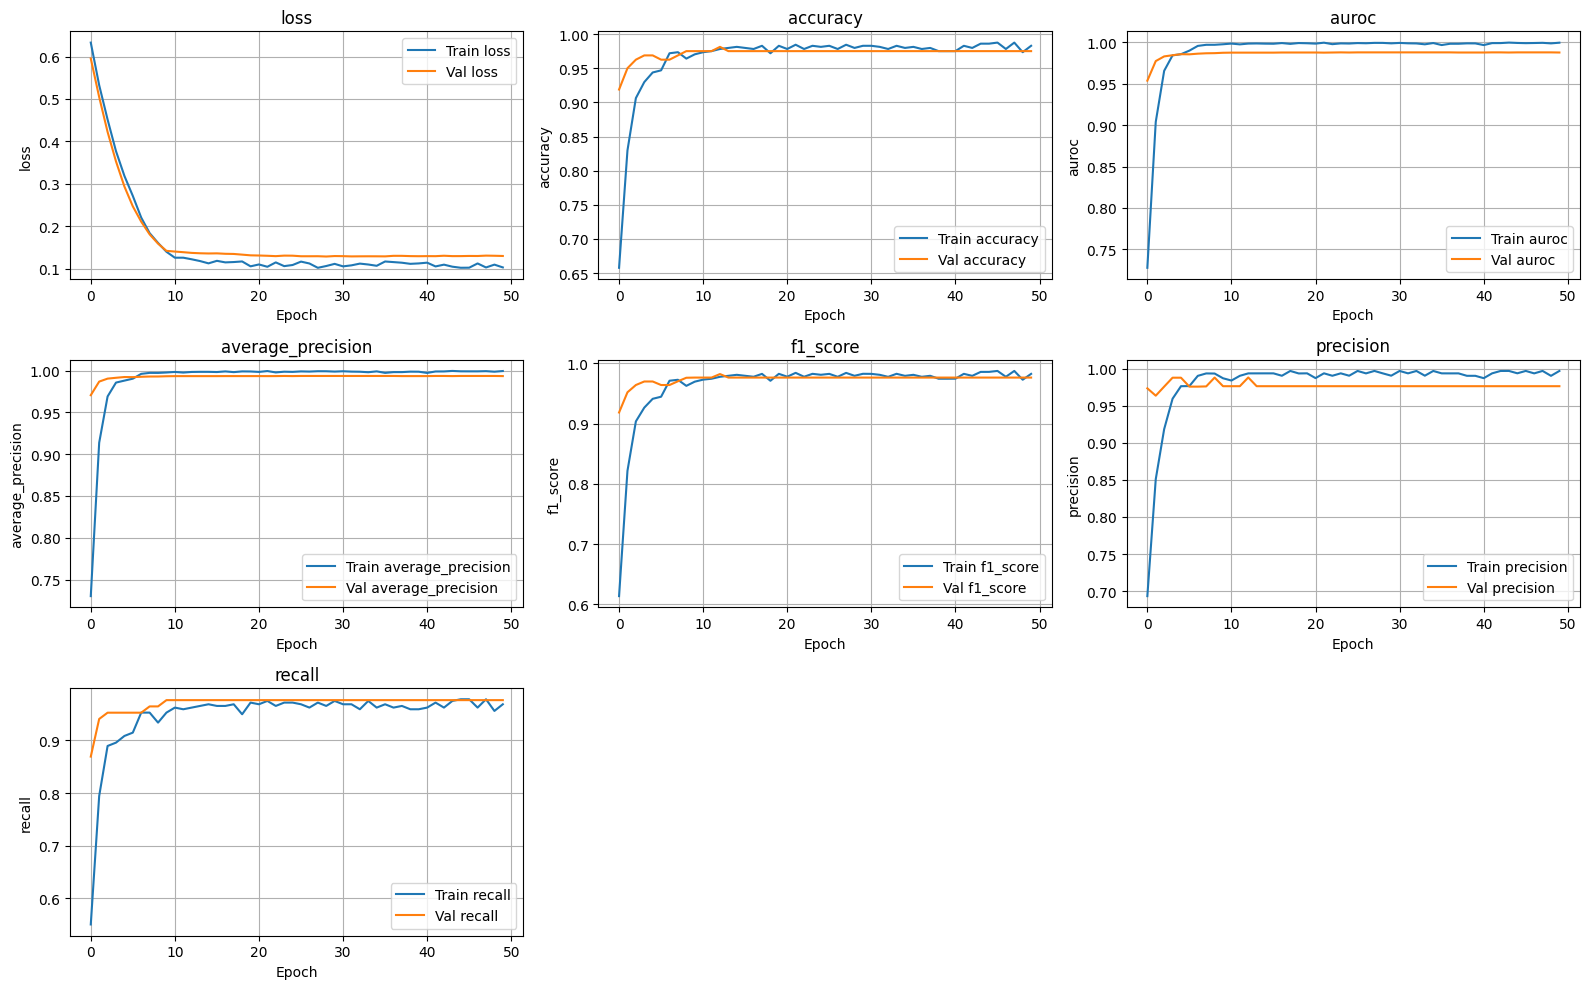

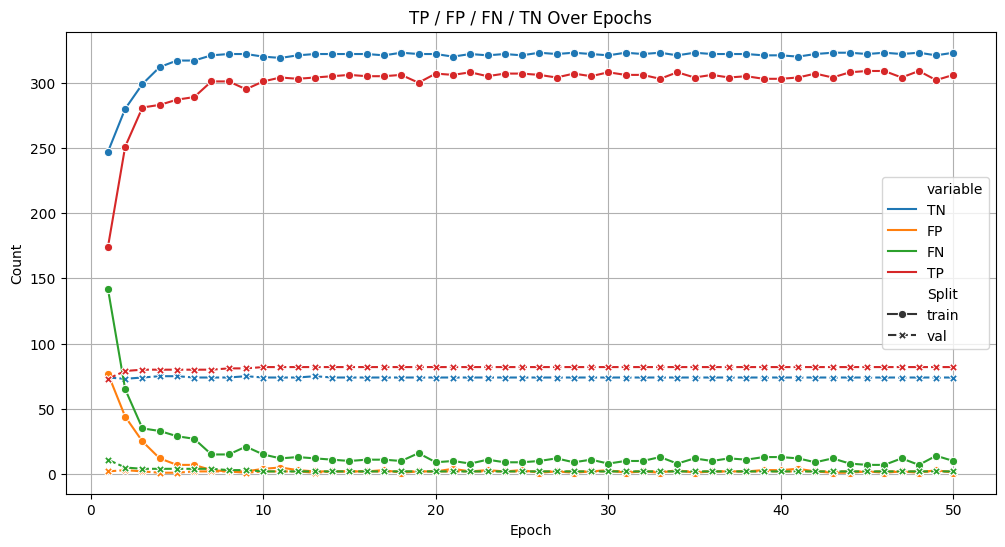

In [ ]:
history_best_fold = history[results['best_fold']]
kFoldTrainerANN.plot_history(history_best_fold)

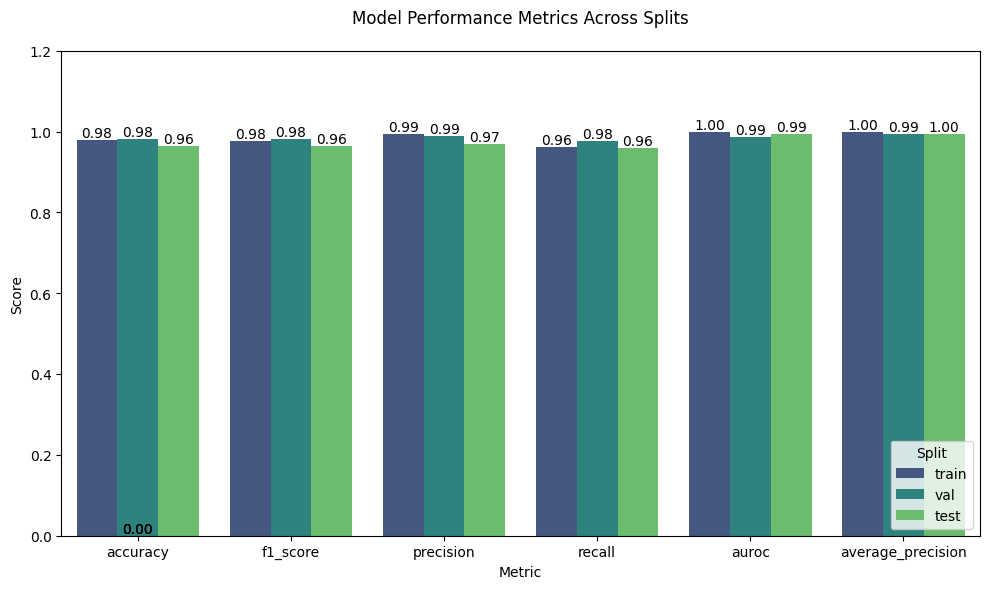

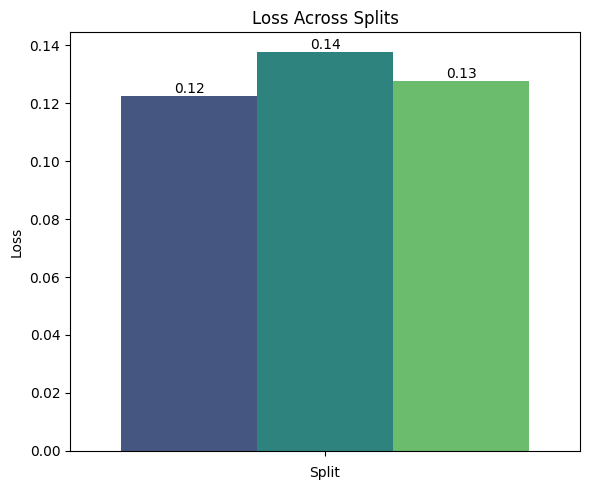

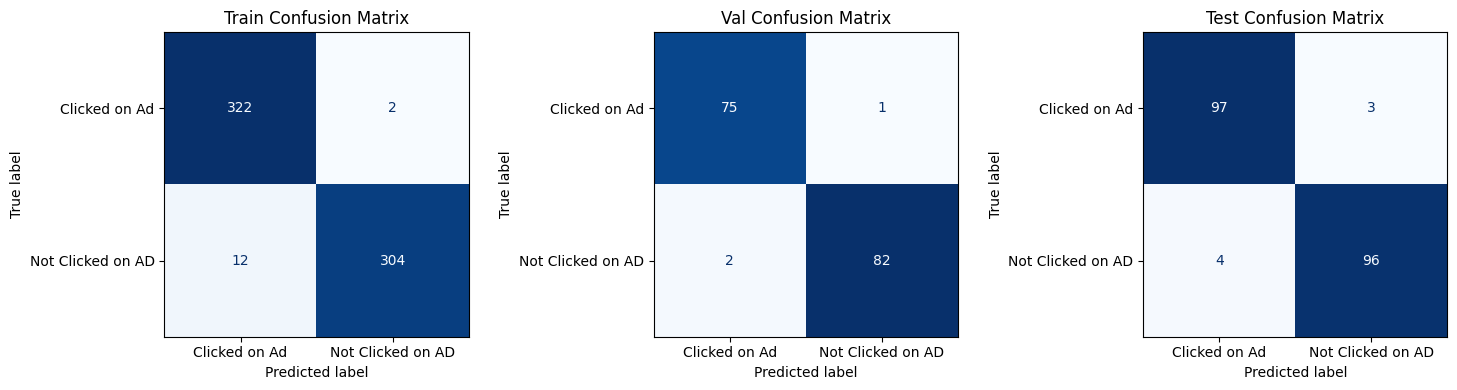

In [ ]:
kFoldTrainerANN.model_performance(results)

# Predictions

In [ ]:
X = pd.DataFrame(ann_X_test, columns=df.drop(columns=['Clicked on Ad']).columns)
y = pd.Series(ann_y_test, name='Clicked on Ad')

X.shape, y.shape



((200, 18), (200,))

In [ ]:
prediction_results = kFoldTrainerANN.predict(X, y, best_pipeline_path=results.get('best_pipeline_path'), best_model_path=results.get('best_model_path'))
prediction_results

 Loaded best model from: /content/checkpoints/best_model.pt
 Loaded pipeline from: /content/checkpoints/pipeline.pkl



{'probs': tensor([0.8686, 0.9924, 0.9705, 0.9574, 0.0531, 0.2505, 0.1417, 0.9912, 0.4000,
         0.9950, 0.1271, 0.9548, 0.9959, 0.0750, 0.9904, 0.9938, 0.9974, 0.9586,
         0.2370, 0.9930, 0.1342, 0.7858, 0.9960, 0.3681, 0.0891, 0.9901, 0.2698,
         0.1997, 0.9593, 0.9412, 0.2486, 0.5741, 0.2330, 0.7779, 0.9776, 0.0557,
         0.1112, 0.4125, 0.9767, 0.9915, 0.0923, 0.9930, 0.3071, 0.9889, 0.0751,
         0.1271, 0.9625, 0.9961, 0.3534, 0.9781, 0.9954, 0.1051, 0.9536, 0.1257,
         0.1644, 0.1342, 0.2271, 0.9882, 0.0558, 0.9837, 0.0833, 0.9769, 0.1004,
         0.9937, 0.7871, 0.9829, 0.9865, 0.0790, 0.9784, 0.9698, 0.9486, 0.9405,
         0.7671, 0.0631, 0.7367, 0.5085, 0.1706, 0.9931, 0.9456, 0.1230, 0.9952,
         0.9692, 0.9739, 0.8907, 0.0652, 0.0780, 0.4630, 0.1433, 0.0966, 0.0763,
         0.1342, 0.8724, 0.1038, 0.9728, 0.1999, 0.4369, 0.9961, 0.9710, 0.1846,
         0.1164, 0.9408, 0.0891, 0.9902, 0.1087, 0.9774, 0.3713, 0.9512, 0.3807,
         0.9939, 0.

In [ ]:
# Calculate metrics
accuracy = accuracy_score(prediction_results['labels'], prediction_results['preds'])
precision = precision_score(prediction_results['labels'], prediction_results['preds'])
recall = recall_score(prediction_results['labels'], prediction_results['preds'])
f1 = f1_score(prediction_results['labels'], prediction_results['preds'])
roc_auc = roc_auc_score(prediction_results['labels'], prediction_results['probs'])
cm = confusion_matrix(prediction_results['labels'], prediction_results['preds'])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

ann_model_metrics = {
    "Model": "ANN",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Confusion Matrix": cm
}

Accuracy: 0.9600
Precision: 0.9813
Recall: 0.9459
F1 Score: 0.9633
ROC AUC Score: 0.9864


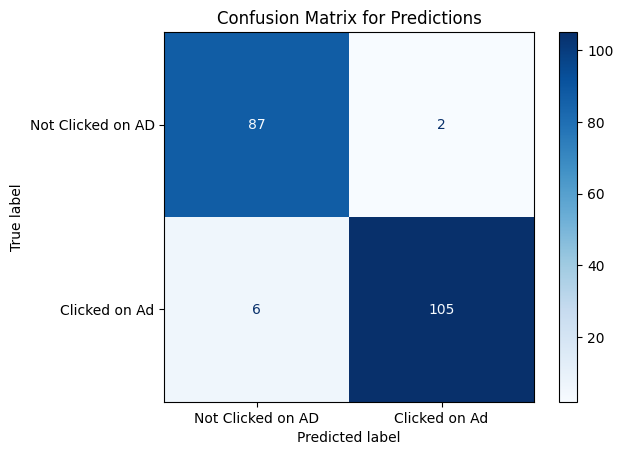

In [ ]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Clicked on AD", "Clicked on Ad"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Predictions")
plt.show()

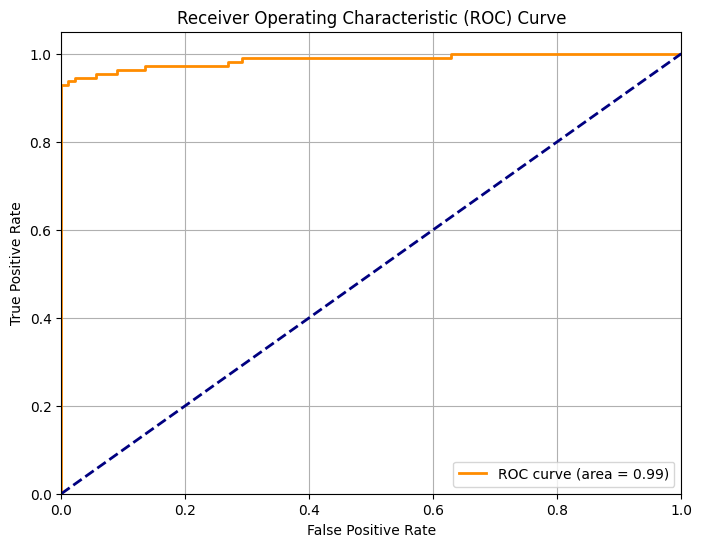

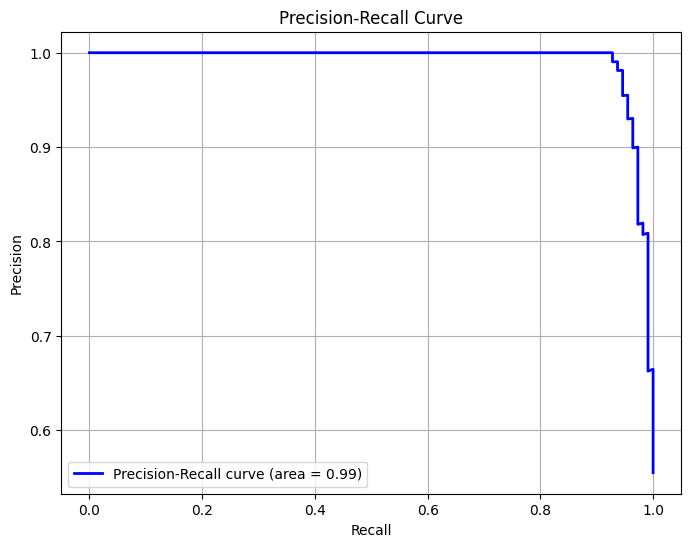

In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(prediction_results['labels'], prediction_results['probs'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(prediction_results['labels'], prediction_results['probs'])
ap = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % ap)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [ ]:
compare_model_metrics = base_model_metrics + [ann_model_metrics]
compare_model_metrics

[{'Model': 'Logistic Regression',
  'Accuracy': 0.95,
  'Precision': 0.9719626168224299,
  'Recall': 0.9369369369369369,
  'F1 Score': 0.9541284403669725,
  'ROC AUC': np.float64(0.983804028747849),
  'Confusion Matrix': array([[ 86,   3],
         [  7, 104]])},
 {'Model': 'Decision Tree',
  'Accuracy': 0.925,
  'Precision': 0.9363636363636364,
  'Recall': 0.9279279279279279,
  'F1 Score': 0.9321266968325792,
  'ROC AUC': np.float64(0.9246381212673347),
  'Confusion Matrix': array([[ 82,   7],
         [  8, 103]])},
 {'Model': 'Random Forest',
  'Accuracy': 0.93,
  'Precision': 0.944954128440367,
  'Recall': 0.9279279279279279,
  'F1 Score': 0.9363636363636364,
  'ROC AUC': np.float64(0.9770725781961735),
  'Confusion Matrix': array([[ 83,   6],
         [  8, 103]])},
 {'Model': 'ANN',
  'Accuracy': 0.96,
  'Precision': 0.9813084112149533,
  'Recall': 0.9459459459459459,
  'F1 Score': 0.963302752293578,
  'ROC AUC': np.float64(0.9864358740763235),
  'Confusion Matrix': array([[ 87, 

In [ ]:
metrics_df = pd.DataFrame(compare_model_metrics)
metrics_df

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0  Logistic Regression     0.950   0.971963  0.936937  0.954128  0.983804   
1        Decision Tree     0.925   0.936364  0.927928  0.932127  0.924638   
2        Random Forest     0.930   0.944954  0.927928  0.936364  0.977073   
3                  ANN     0.960   0.981308  0.945946  0.963303  0.986436   

      Confusion Matrix  
0  [[86, 3], [7, 104]]  
1  [[82, 7], [8, 103]]  
2  [[83, 6], [8, 103]]  
3  [[87, 2], [6, 105]]

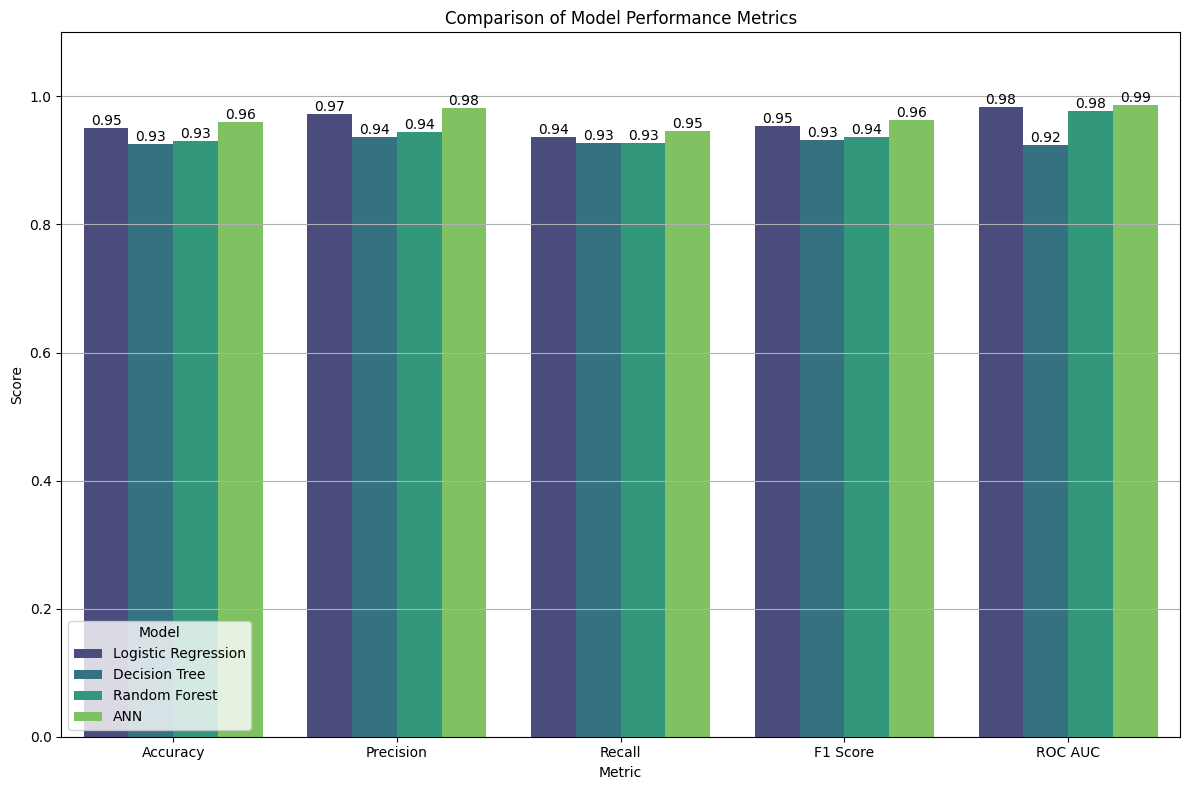

In [ ]:
metrics_df_melted = metrics_df.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=metrics_df_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1.1) # Increase y-axis limit to make space for labels
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()

# Add values on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

plt.show()

## Model Performance Inference

Based on the metrics provided in the `metrics_df` and the performance plots:

1.  **ANN Model Performance:** The Artificial Neural Network (ANN) model appears to be the best performing model among the ones evaluated.
    *   It achieved the highest **Accuracy (0.960)**, indicating its overall correctness in predictions.
    *   It also has the highest **Precision (0.981)**, suggesting a low rate of false positives (when the model predicts a click but it wasn't clicked).
    *   The **F1 Score (0.963)** is also the highest for the ANN, which is a good balance between precision and recall.
    *   The **ROC AUC (0.986)** is very close to 1, indicating excellent discriminatory power of the model.

2.  **Comparison with Base Models:** The ANN model consistently outperforms the traditional machine learning models (Logistic Regression, Decision Tree, and Random Forest) across all evaluated metrics (Accuracy, Precision, Recall, F1 Score, and ROC AUC).

3.  **Confusion Matrix Analysis:** The confusion matrix for the ANN model shows a low number of false positives (2) and false negatives (6) on the test set, further supporting its strong performance.

4.  **Training History (from the best fold):**
    *   The training and validation loss curves show that the model quickly converges within the first few epochs and then stabilizes.
    *   The accuracy, precision, recall, F1 score, AUROC, and Average Precision metrics on both the training and validation sets increase rapidly in the initial epochs and then plateau, suggesting that the model is learning effectively without significant overfitting (as the validation metrics track closely with the training metrics).
    *   The TP (True Positives) and TN (True Negatives) counts increase, while FP (False Positives) and FN (False Negatives) counts decrease over epochs, which aligns with the improving performance metrics.

In summary, the ANN model, with the implemented preprocessing and embedding layers for categorical features, demonstrates superior performance for this classification task compared to the simpler base models.

In [ ]:
# END